In [1]:
%config InlineBackend.figure_format = 'retina'

In [65]:
import os
import re
import math
import scvelo as scv
import pickle5 as pkl
import numpy as np
import scanpy as sc
from collections import Counter
from glob import glob
import pandas as pd
from copy import deepcopy
from scipy.stats import pearsonr, ranksums, ttest_ind
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

In [3]:
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

In [4]:
def my_vmax(values): 
    return (np.percentile(values, 99)+np.max(values))/2

In [5]:
scv.set_figure_params(figsize=(5,8), transparent=False, facecolor='white')

In [6]:
indir = '~/decidua/10xVisium/file/new'
scv.settings.figdir = '~/decidua/10xVisium/plot/new/velo'

In [7]:
path = os.path.join(indir,'SPACEL/Normal_crop_coord.pkl')
with open(path, 'rb') as handle:
    coord_dict = pkl.load(handle, )
    
path = os.path.join(indir,'SPACEL/RPL_crop_coord.pkl')
with open(path, 'rb') as handle:
    rpl_coord_dict = pkl.load(handle)
    
coord_dict.update(rpl_coord_dict)

In [8]:
order_ctypes = ['dNKp','dNK1','dNK2','dNK3','dM1','dM2','CD4T','CD8T','Treg',
                'DC','dS1','dS2','dS3','Epi','Endo','PV','EVT']

In [9]:
ad_loom = scv.read('~/decidua/scRNA/hg38/RPL/combine.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
def run_velo_para_rpl(slide, cut_prob=0.05):
    path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
    ad_sp = sc.read_h5ad(path)

    clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
    clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

    path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
    ad_map = sc.read_h5ad(path)

    cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

    ad_sc = sc.read_h5ad('~/decidua/scRNA/hg38/RPL/dda_all.merge_our_immune.only_RPL.h5ad')
    # ad_sc = ad_sc[ad_sc.obs['cell.type']!='NKT']
    celltype = ad_sc.obs[['cell.type']]
    celltype.columns = ['cell.type2']

    ### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
    max_id = cells_data.values.argmax(axis=1)
    data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                            index=cells_data.index, columns=cells_data.columns)
    for i in range(len(data_new.index.tolist())):
        data_new.iloc[i,max_id[i]] = 1

    ### 生成细胞与细胞类型对应的01矩阵
    celltype = celltype.loc[data_new.index]
    celltype['cell'] = celltype.index
    celltype['value'] = 1
    celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
    celltype = celltype.loc[data_new.index]

    ### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
    spot_ct = np.dot(data_new.T,celltype)
    spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)
    spot_ct = spot_ct.loc[:,~spot_ct.columns.str.startswith('NKT')]

    ### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
    data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                     index=clusters_data.index,columns=clusters_data.columns)
    clusters_mean = clusters_data.mean(axis=0)

    ##### i为列 j为行
    for i in range(clusters_data.shape[1]):
        for j in range(clusters_data.shape[0]):
            if clusters_data.iloc[j,i] > clusters_mean[i]:
                data_new_clusters.iloc[j,i]=1
    data_new_clusters = data_new_clusters.loc[spot_ct.index]
    data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

    ### 取spot_ct与data_new_clusters交集为富集spot
    data_filter = np.multiply(spot_ct, data_new_clusters)

    ### 根据data_new得到cell与spot的对应关系 
    data_new['cell'] = data_new.index
    cell_map_spot = data_new.melt(id_vars=['cell'])
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
    del cell_map_spot['value']
    cell_map_spot.columns = ['cell','spot']

    ##### 重新读celltype命名为celltypes 赋给cell_map_spot
    celltypes = ad_sc.obs[['cell.type']]
    celltypes.columns = ['cell.type2']

    celltypes = celltypes.loc[cell_map_spot['cell']]
    cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

    ### 根据 data_filter 得到细胞类型的过滤器
    data_filter.columns = data_filter.columns.astype(str)
    data_filter['spot'] = data_filter.index
    celltype_filter = data_filter.melt(id_vars=['spot'])
    celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

    ### cell_map_spot按照celltype_filter结果筛选
    cell_map_spot['filter'] = 0
    for i in cell_map_spot.index:
        map_spot = cell_map_spot.loc[i,'spot']
        map_celltype = cell_map_spot.loc[i,'cell_type']
        if map_spot in celltype_filter['spot'].tolist():
            data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
            if map_celltype in data_celltype_filter['cell.type2'].tolist():
                cell_map_spot.loc[i,'filter'] = 1
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
    del cell_map_spot['filter']
    cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

    decon = deepcopy(cell_map_spot)
    # prob = deepcopy(clusters_data)
    path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
    prob = pd.read_csv(path, index_col=0)

    with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
        meta = pkl.load(f)

    import random

    decon[['x','y']] = 0
    for i in range(len(decon)):
        get_spot = decon.iloc[i,0]
        get_position = meta.loc[get_spot,'cell_position']
        if get_position.shape[0] != 0:
            get_position_id = random.sample(range(len(get_position)),1)[0]
            decon.iloc[i,3] = get_position[get_position_id,0]
            decon.iloc[i,4] = get_position[get_position_id,1]
        else:
            get_position = ad_sp.obs.loc[get_spot,['x','y']]
            decon.iloc[i,3] = get_position[0]
            decon.iloc[i,4] = get_position[1]

    ad_loom_rnav = deepcopy(ad_loom)

    index = ad_loom_rnav.obs.index.tolist()

    new_index = []
    for idx in index:
        if re.match('scRNA1',idx):
            new_idx = 'our_'+idx.split(':')[1][:-1]+'-2'
        elif re.match('scRNA2',idx):
            new_idx = 'our_'+idx.split(':')[1][:-1]+'-4'
        new_index.append(new_idx)

    ad_loom_rnav.obs.index = new_index

    sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
    ad_sc = ad_sc[sel_overlop]

    dNK = pd.DataFrame()
    for j in ['dNK1','dNK2','dNK3', 'dNKp']:
        for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
            spot = decon.loc[decon.loc[:,'spot']==i,:]
            spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
            dNK = dNK.append(spot_sel)

    dNK.index = dNK['cell']
    print(slide, cut_prob)
    print(dNK['cell_type'].value_counts())

    dNK.index = dNK['cell']
    adata_dNK = ad_sc[dNK.index,:]
    adata_dNK.obs = dNK
    adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
    splice_tsne = dNK.loc[:,['x','y']]
    adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

    scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata_scv_dNK)
    scv.tl.velocity_graph(adata_scv_dNK)

    scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type',
                                     size=25, legend_loc='right margin', alpha=0.7, 
                                     save='dNK.'+str(cut_prob)+'.'+slide+'.png', show=False)
    

In [9]:
# disease_slices = ['B1_P4','C1_P8B','D1_P9T','D1_P9B']
# for cut_prob in [0.001, 0.005, 0.01, 0.03, 0.05, 0.07]:
#     for slide in disease_slices:
#         run_velo_para_rpl(slide, cut_prob=cut_prob)

In [11]:
disease_slices = ['B1_P4','C1_P8B','D1_P9T','D1_P9B']
for cut_prob in [0.001, 0.005, 0.01, 0.03, 0.05, 0.07]:
    for slide in disease_slices:
        path = os.path.join('~/decidua/10xVisium/plot/new/velo', f'scvelo_dNK.{cut_prob}.{slide}.png')
        if os.path.exists(path):
            pass
        else:
            print('No')
#             run_velo_para_rpl(slide, cut_prob=cut_prob)

In [12]:
scv.settings.figdir = '~/decidua/10xVisium/plot/new/velo/smooth'

In [13]:
def run_velo_para_rpl_smooth(slide, cut_prob=0.05):
    path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
    ad_sp = sc.read_h5ad(path)

    clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
    clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

    path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
    ad_map = sc.read_h5ad(path)

    cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

    ad_sc = sc.read_h5ad('~/decidua/scRNA/hg38/RPL/dda_all.merge_our_immune.only_RPL.h5ad')
    # ad_sc = ad_sc[ad_sc.obs['cell.type']!='NKT']
    celltype = ad_sc.obs[['cell.type']]
    celltype.columns = ['cell.type2']

    ### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
    max_id = cells_data.values.argmax(axis=1)
    data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                            index=cells_data.index, columns=cells_data.columns)
    for i in range(len(data_new.index.tolist())):
        data_new.iloc[i,max_id[i]] = 1

    ### 生成细胞与细胞类型对应的01矩阵
    celltype = celltype.loc[data_new.index]
    celltype['cell'] = celltype.index
    celltype['value'] = 1
    celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
    celltype = celltype.loc[data_new.index]

    ### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
    spot_ct = np.dot(data_new.T,celltype)
    spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)
    spot_ct = spot_ct.loc[:,~spot_ct.columns.str.startswith('NKT')]

    ### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
    data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                     index=clusters_data.index,columns=clusters_data.columns)
    clusters_mean = clusters_data.mean(axis=0)

    ##### i为列 j为行
    for i in range(clusters_data.shape[1]):
        for j in range(clusters_data.shape[0]):
            if clusters_data.iloc[j,i] > clusters_mean[i]:
                data_new_clusters.iloc[j,i]=1
    data_new_clusters = data_new_clusters.loc[spot_ct.index]
    data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

    ### 取spot_ct与data_new_clusters交集为富集spot
    data_filter = np.multiply(spot_ct, data_new_clusters)

    ### 根据data_new得到cell与spot的对应关系 
    data_new['cell'] = data_new.index
    cell_map_spot = data_new.melt(id_vars=['cell'])
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
    del cell_map_spot['value']
    cell_map_spot.columns = ['cell','spot']

    ##### 重新读celltype命名为celltypes 赋给cell_map_spot
    celltypes = ad_sc.obs[['cell.type']]
    celltypes.columns = ['cell.type2']

    celltypes = celltypes.loc[cell_map_spot['cell']]
    cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

    ### 根据 data_filter 得到细胞类型的过滤器
    data_filter.columns = data_filter.columns.astype(str)
    data_filter['spot'] = data_filter.index
    celltype_filter = data_filter.melt(id_vars=['spot'])
    celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

    ### cell_map_spot按照celltype_filter结果筛选
    cell_map_spot['filter'] = 0
    for i in cell_map_spot.index:
        map_spot = cell_map_spot.loc[i,'spot']
        map_celltype = cell_map_spot.loc[i,'cell_type']
        if map_spot in celltype_filter['spot'].tolist():
            data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
            if map_celltype in data_celltype_filter['cell.type2'].tolist():
                cell_map_spot.loc[i,'filter'] = 1
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
    del cell_map_spot['filter']
    cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

    decon = deepcopy(cell_map_spot)
    # prob = deepcopy(clusters_data)
    path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
    prob = pd.read_csv(path, index_col=0)

    with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
        meta = pkl.load(f)

    import random

    decon[['x','y']] = 0
    for i in range(len(decon)):
        get_spot = decon.iloc[i,0]
        get_position = meta.loc[get_spot,'cell_position']
        if get_position.shape[0] != 0:
            get_position_id = random.sample(range(len(get_position)),1)[0]
            decon.iloc[i,3] = get_position[get_position_id,0]
            decon.iloc[i,4] = get_position[get_position_id,1]
        else:
            get_position = ad_sp.obs.loc[get_spot,['x','y']]
            decon.iloc[i,3] = get_position[0]
            decon.iloc[i,4] = get_position[1]

    ad_loom_rnav = deepcopy(ad_loom)

    index = ad_loom_rnav.obs.index.tolist()

    new_index = []
    for idx in index:
        if re.match('scRNA1',idx):
            new_idx = 'our_'+idx.split(':')[1][:-1]+'-2'
        elif re.match('scRNA2',idx):
            new_idx = 'our_'+idx.split(':')[1][:-1]+'-4'
        new_index.append(new_idx)

    ad_loom_rnav.obs.index = new_index

    sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
    ad_sc = ad_sc[sel_overlop]

    dNK = pd.DataFrame()
    for j in ['dNK1','dNK2','dNK3', 'dNKp']:
        for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
            spot = decon.loc[decon.loc[:,'spot']==i,:]
            spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
            dNK = dNK.append(spot_sel)

    dNK.index = dNK['cell']
    print(slide, cut_prob)
    print(dNK['cell_type'].value_counts())

    dNK.index = dNK['cell']
    adata_dNK = ad_sc[dNK.index,:]
    adata_dNK.obs = dNK
    adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
    splice_tsne = dNK.loc[:,['x','y']]
    adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

    scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata_scv_dNK)
    scv.tl.velocity_graph(adata_scv_dNK)

    scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type',
                                     size=25, legend_loc='right margin', alpha=0.7, smooth=1,
                                     save='dNK.'+str(cut_prob)+'.'+slide+'.png', show=False)
    

In [15]:
for cut_prob in [0.01, 0.03, 0.05, 0.07]:
    for slide in disease_slices:
        path = os.path.join('~/decidua/10xVisium/plot/new/velo/smooth', f'scvelo_dNK.{cut_prob}.{slide}.png')
        if os.path.exists(path):
            pass
        else:
            run_velo_para_rpl_smooth(slide, cut_prob=cut_prob)

# plot

In [84]:
outdir = '~/decidua/10xVisium/plot/new/RPL'

In [17]:
slide = 'C1_P8B'
cut_prob = 0.05

In [18]:

path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
ad_sp = sc.read_h5ad(path)

clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
ad_map = sc.read_h5ad(path)

cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

ad_sc = sc.read_h5ad('~/decidua/scRNA/hg38/RPL/dda_all.merge_our_immune.only_RPL.h5ad')
# ad_sc = ad_sc[ad_sc.obs['cell.type']!='NKT']
celltype = ad_sc.obs[['cell.type']]
celltype.columns = ['cell.type2']

### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
max_id = cells_data.values.argmax(axis=1)
data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                        index=cells_data.index, columns=cells_data.columns)
for i in range(len(data_new.index.tolist())):
    data_new.iloc[i,max_id[i]] = 1

### 生成细胞与细胞类型对应的01矩阵
celltype = celltype.loc[data_new.index]
celltype['cell'] = celltype.index
celltype['value'] = 1
celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
celltype = celltype.loc[data_new.index]

### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
spot_ct = np.dot(data_new.T,celltype)
spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)
spot_ct = spot_ct.loc[:,~spot_ct.columns.str.startswith('NKT')]

### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                 index=clusters_data.index,columns=clusters_data.columns)
clusters_mean = clusters_data.mean(axis=0)

##### i为列 j为行
for i in range(clusters_data.shape[1]):
    for j in range(clusters_data.shape[0]):
        if clusters_data.iloc[j,i] > clusters_mean[i]:
            data_new_clusters.iloc[j,i]=1
data_new_clusters = data_new_clusters.loc[spot_ct.index]
data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

### 取spot_ct与data_new_clusters交集为富集spot
data_filter = np.multiply(spot_ct, data_new_clusters)

### 根据data_new得到cell与spot的对应关系 
data_new['cell'] = data_new.index
cell_map_spot = data_new.melt(id_vars=['cell'])
cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
del cell_map_spot['value']
cell_map_spot.columns = ['cell','spot']

##### 重新读celltype命名为celltypes 赋给cell_map_spot
celltypes = ad_sc.obs[['cell.type']]
celltypes.columns = ['cell.type2']

celltypes = celltypes.loc[cell_map_spot['cell']]
cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

### 根据 data_filter 得到细胞类型的过滤器
data_filter.columns = data_filter.columns.astype(str)
data_filter['spot'] = data_filter.index
celltype_filter = data_filter.melt(id_vars=['spot'])
celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

### cell_map_spot按照celltype_filter结果筛选
cell_map_spot['filter'] = 0
for i in cell_map_spot.index:
    map_spot = cell_map_spot.loc[i,'spot']
    map_celltype = cell_map_spot.loc[i,'cell_type']
    if map_spot in celltype_filter['spot'].tolist():
        data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
        if map_celltype in data_celltype_filter['cell.type2'].tolist():
            cell_map_spot.loc[i,'filter'] = 1
cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
del cell_map_spot['filter']
cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

decon = deepcopy(cell_map_spot)
# prob = deepcopy(clusters_data)
path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
prob = pd.read_csv(path, index_col=0)

with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
    meta = pkl.load(f)

import random

decon[['x','y']] = 0
for i in range(len(decon)):
    get_spot = decon.iloc[i,0]
    get_position = meta.loc[get_spot,'cell_position']
    if get_position.shape[0] != 0:
        get_position_id = random.sample(range(len(get_position)),1)[0]
        decon.iloc[i,3] = get_position[get_position_id,0]
        decon.iloc[i,4] = get_position[get_position_id,1]
    else:
        get_position = ad_sp.obs.loc[get_spot,['x','y']]
        decon.iloc[i,3] = get_position[0]
        decon.iloc[i,4] = get_position[1]

ad_loom_rnav = deepcopy(ad_loom)

index = ad_loom_rnav.obs.index.tolist()

new_index = []
for idx in index:
    if re.match('scRNA1',idx):
        new_idx = 'our_'+idx.split(':')[1][:-1]+'-2'
    elif re.match('scRNA2',idx):
        new_idx = 'our_'+idx.split(':')[1][:-1]+'-4'
    new_index.append(new_idx)

ad_loom_rnav.obs.index = new_index

sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
ad_sc = ad_sc[sel_overlop]

dNK = pd.DataFrame()
for j in ['dNK1','dNK2','dNK3', 'dNKp']:
    for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
        spot = decon.loc[decon.loc[:,'spot']==i,:]
        spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
        dNK = dNK.append(spot_sel)

dNK.index = dNK['cell']
print(slide, cut_prob)
print(dNK['cell_type'].value_counts())

dNK.index = dNK['cell']
adata_dNK = ad_sc[dNK.index,:]
adata_dNK.obs = dNK
adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
splice_tsne = dNK.loc[:,['x','y']]
adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata_scv_dNK)
scv.tl.velocity_graph(adata_scv_dNK)


C1_P8B 0.05
dNK2    1221
dNK3     798
dNK1     325
dNKp       6
Name: cell_type, dtype: int64
Filtered out 15325 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


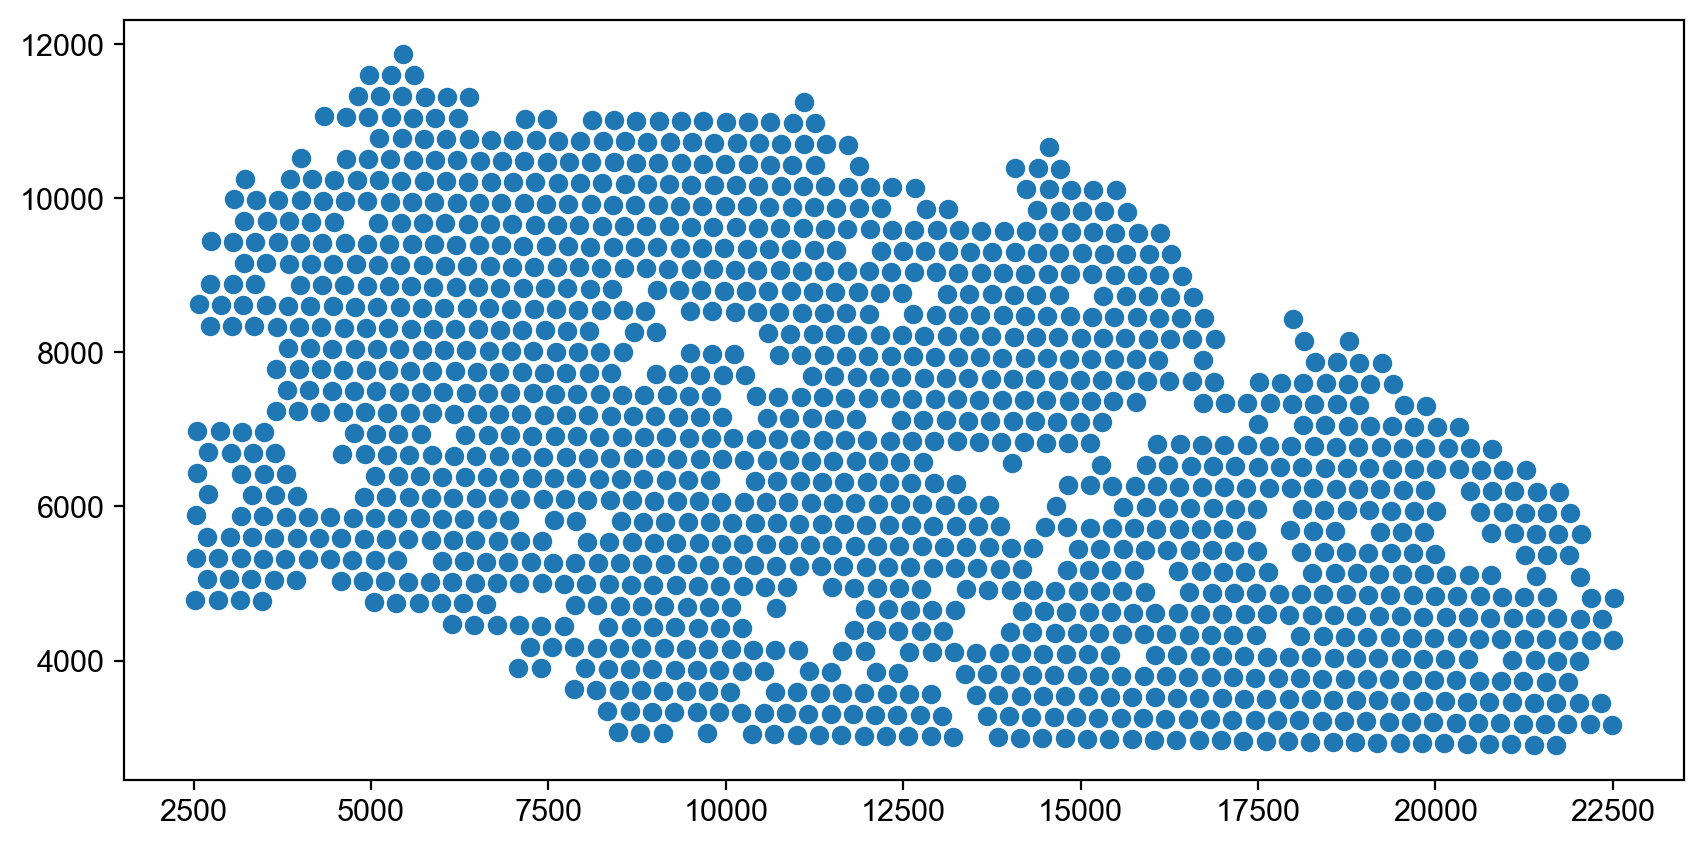

In [26]:
plt.figure(figsize=(10,5))
plt.scatter(ad_sp.obs['x'], ad_sp.obs['y'])

In [36]:
coord_dict[slide]

[2285, 22751, 2664, 12110]

In [39]:
adata_scv_dNK.obs['cell_type'] = pd.Categorical(adata_scv_dNK.obs['cell_type'], categories=['dNKp','dNK1','dNK2','dNK3'])

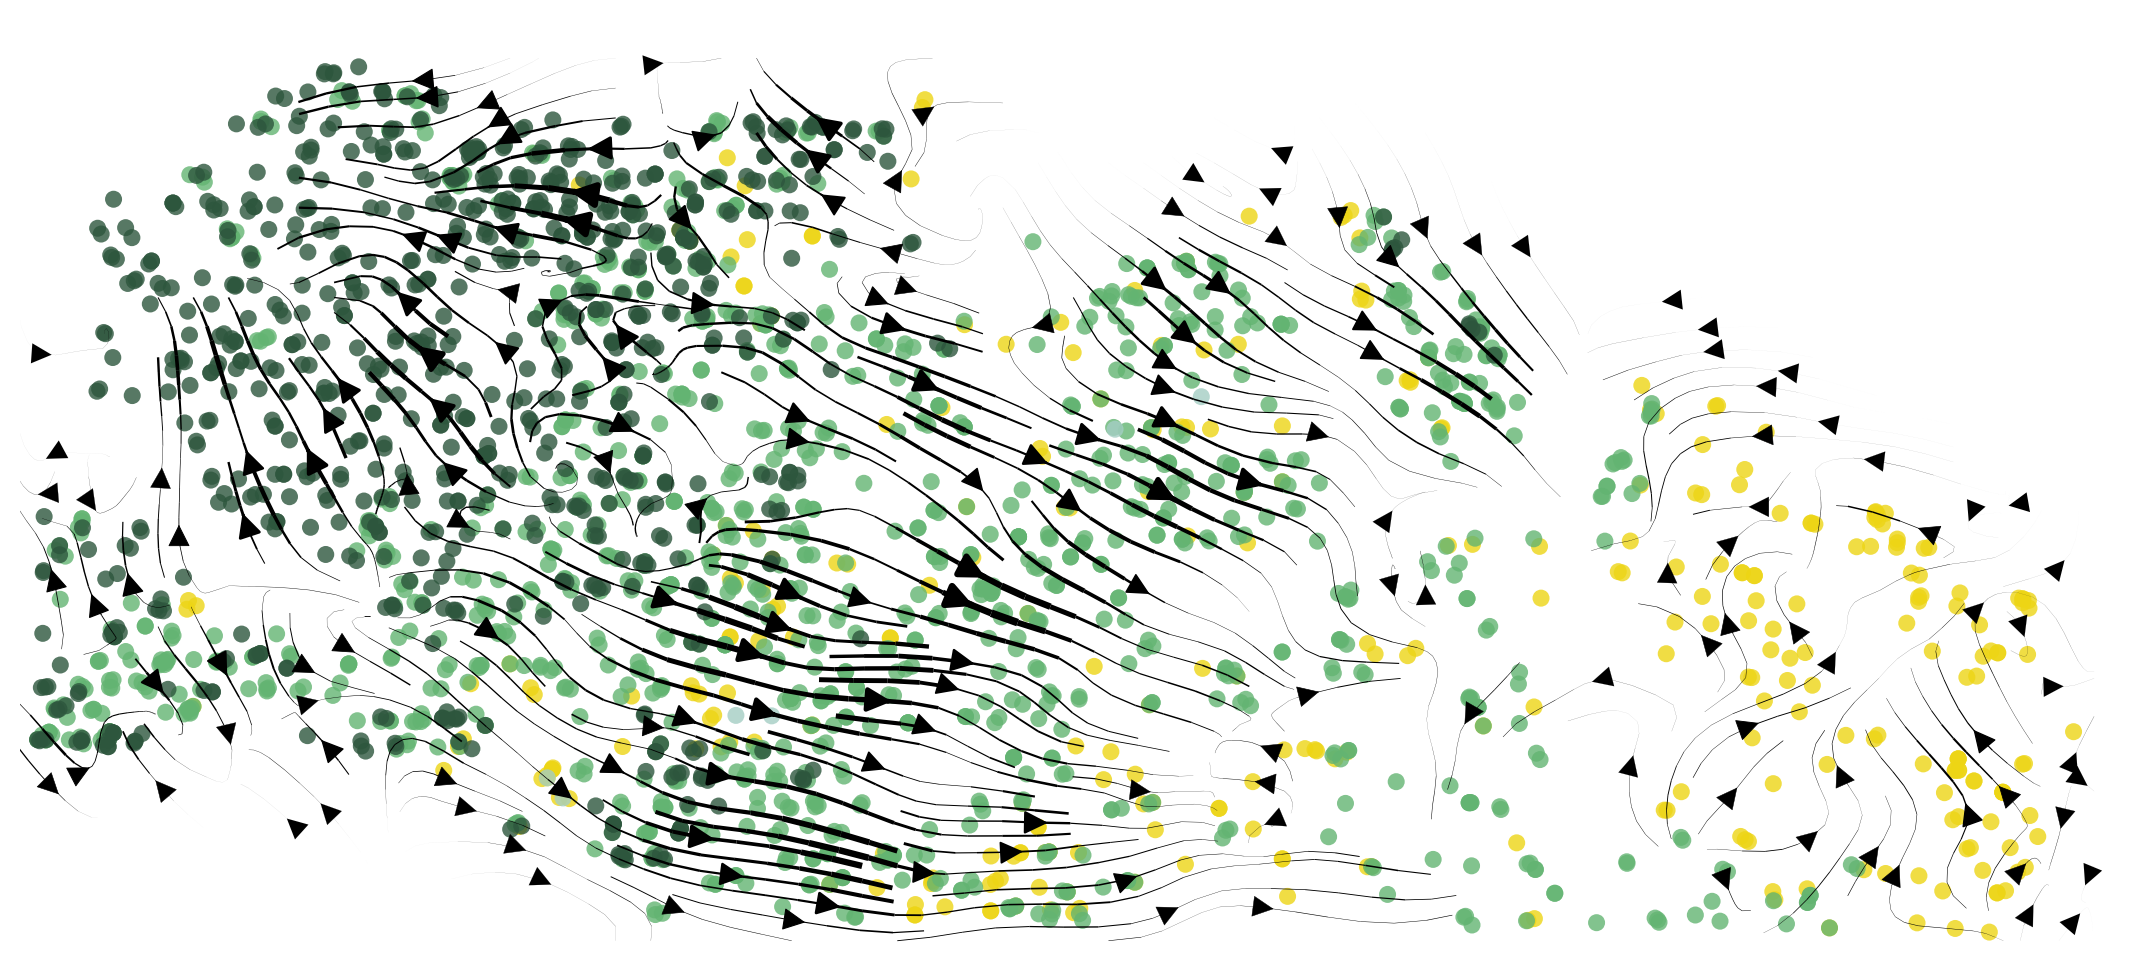

In [66]:
h = 5
plt.figure(figsize=(2.18*h, h))
ax21 = plt.subplot(111)
scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type', 
                                 xlim=[coord_dict[slide][0],coord_dict[slide][1]], 
                                 ylim=[coord_dict[slide][2],coord_dict[slide][3]],
                                 size=150, arrow_size=1.8, linewidth=1.5, alpha=0.8, 
                                 palette=['#a4cec4', '#edd515','#63B472','#2D563D'], 
                                 title='', legend_loc='right margin', smooth=1,
                                 ax=ax21, show=False)
ax21.get_legend().remove()
plt.tight_layout()
plt.savefig(outdir+'/'+slide+'_scvelo.png', dpi=1000)

In [67]:
slide = 'D1_P9T'
cut_prob = 0.05

In [68]:

path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
ad_sp = sc.read_h5ad(path)

clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
ad_map = sc.read_h5ad(path)

cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

ad_sc = sc.read_h5ad('~/decidua/scRNA/hg38/RPL/dda_all.merge_our_immune.only_RPL.h5ad')
# ad_sc = ad_sc[ad_sc.obs['cell.type']!='NKT']
celltype = ad_sc.obs[['cell.type']]
celltype.columns = ['cell.type2']

### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
max_id = cells_data.values.argmax(axis=1)
data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                        index=cells_data.index, columns=cells_data.columns)
for i in range(len(data_new.index.tolist())):
    data_new.iloc[i,max_id[i]] = 1

### 生成细胞与细胞类型对应的01矩阵
celltype = celltype.loc[data_new.index]
celltype['cell'] = celltype.index
celltype['value'] = 1
celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
celltype = celltype.loc[data_new.index]

### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
spot_ct = np.dot(data_new.T,celltype)
spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)
spot_ct = spot_ct.loc[:,~spot_ct.columns.str.startswith('NKT')]

### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                 index=clusters_data.index,columns=clusters_data.columns)
clusters_mean = clusters_data.mean(axis=0)

##### i为列 j为行
for i in range(clusters_data.shape[1]):
    for j in range(clusters_data.shape[0]):
        if clusters_data.iloc[j,i] > clusters_mean[i]:
            data_new_clusters.iloc[j,i]=1
data_new_clusters = data_new_clusters.loc[spot_ct.index]
data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

### 取spot_ct与data_new_clusters交集为富集spot
data_filter = np.multiply(spot_ct, data_new_clusters)

### 根据data_new得到cell与spot的对应关系 
data_new['cell'] = data_new.index
cell_map_spot = data_new.melt(id_vars=['cell'])
cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
del cell_map_spot['value']
cell_map_spot.columns = ['cell','spot']

##### 重新读celltype命名为celltypes 赋给cell_map_spot
celltypes = ad_sc.obs[['cell.type']]
celltypes.columns = ['cell.type2']

celltypes = celltypes.loc[cell_map_spot['cell']]
cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

### 根据 data_filter 得到细胞类型的过滤器
data_filter.columns = data_filter.columns.astype(str)
data_filter['spot'] = data_filter.index
celltype_filter = data_filter.melt(id_vars=['spot'])
celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

### cell_map_spot按照celltype_filter结果筛选
cell_map_spot['filter'] = 0
for i in cell_map_spot.index:
    map_spot = cell_map_spot.loc[i,'spot']
    map_celltype = cell_map_spot.loc[i,'cell_type']
    if map_spot in celltype_filter['spot'].tolist():
        data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
        if map_celltype in data_celltype_filter['cell.type2'].tolist():
            cell_map_spot.loc[i,'filter'] = 1
cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
del cell_map_spot['filter']
cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

decon = deepcopy(cell_map_spot)
# prob = deepcopy(clusters_data)
path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
prob = pd.read_csv(path, index_col=0)

with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
    meta = pkl.load(f)

import random

decon[['x','y']] = 0
for i in range(len(decon)):
    get_spot = decon.iloc[i,0]
    get_position = meta.loc[get_spot,'cell_position']
    if get_position.shape[0] != 0:
        get_position_id = random.sample(range(len(get_position)),1)[0]
        decon.iloc[i,3] = get_position[get_position_id,0]
        decon.iloc[i,4] = get_position[get_position_id,1]
    else:
        get_position = ad_sp.obs.loc[get_spot,['x','y']]
        decon.iloc[i,3] = get_position[0]
        decon.iloc[i,4] = get_position[1]

ad_loom_rnav = deepcopy(ad_loom)

index = ad_loom_rnav.obs.index.tolist()

new_index = []
for idx in index:
    if re.match('scRNA1',idx):
        new_idx = 'our_'+idx.split(':')[1][:-1]+'-2'
    elif re.match('scRNA2',idx):
        new_idx = 'our_'+idx.split(':')[1][:-1]+'-4'
    new_index.append(new_idx)

ad_loom_rnav.obs.index = new_index

sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
ad_sc = ad_sc[sel_overlop]

dNK = pd.DataFrame()
for j in ['dNK1','dNK2','dNK3', 'dNKp']:
    for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
        spot = decon.loc[decon.loc[:,'spot']==i,:]
        spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
        dNK = dNK.append(spot_sel)

dNK.index = dNK['cell']
print(slide, cut_prob)
print(dNK['cell_type'].value_counts())

dNK.index = dNK['cell']
adata_dNK = ad_sc[dNK.index,:]
adata_dNK.obs = dNK
adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
splice_tsne = dNK.loc[:,['x','y']]
adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata_scv_dNK)
scv.tl.velocity_graph(adata_scv_dNK)

D1_P9T 0.05
dNK2    965
dNK3    713
dNK1    296
dNKp      1
Name: cell_type, dtype: int64
Filtered out 15603 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [69]:
adata_scv_dNK.obs['cell_type'] = pd.Categorical(adata_scv_dNK.obs['cell_type'], categories=['dNKp','dNK1','dNK2','dNK3'])

In [72]:
coord_dict[slide]

[6247, 20897, 2820, 11795]

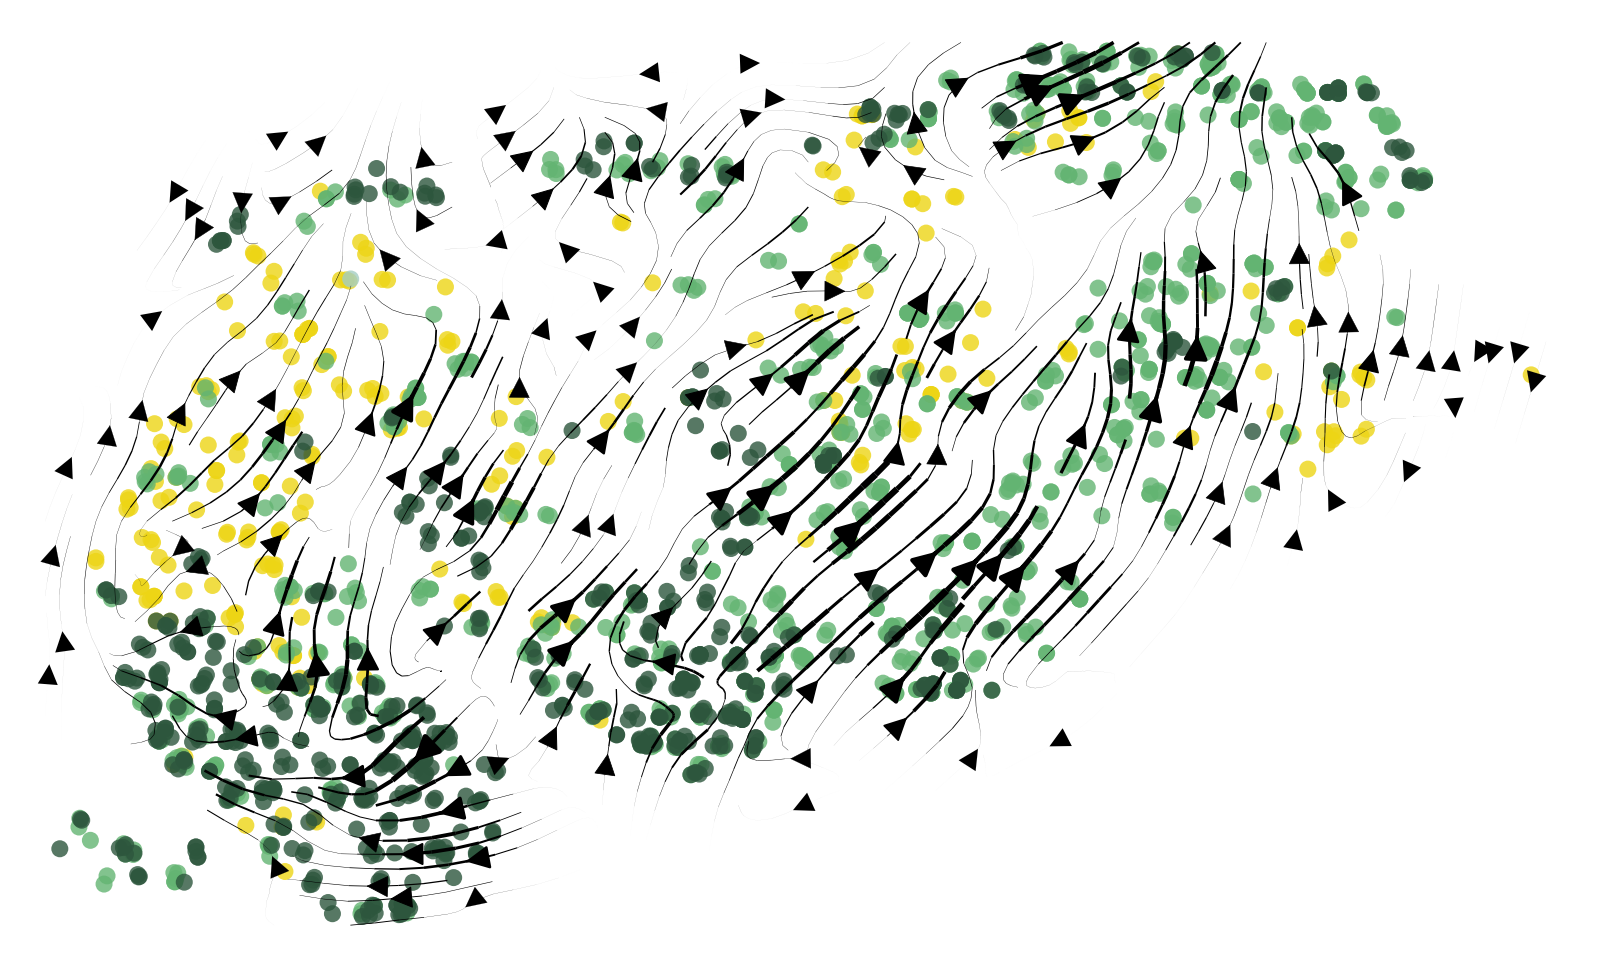

In [96]:
h = 5
plt.figure(figsize=(1.6323*h, h))
ax21 = plt.subplot(111)
scv.pl.velocity_embedding_stream(adata_scv_dNK, basis='umap', color='cell_type', 
                                 xlim=[coord_dict[slide][2]+2000,coord_dict[slide][3]+7200], 
                                 ylim=[coord_dict[slide][0]+7500,coord_dict[slide][1]+1700],
                                 size=150, arrow_size=1.8, linewidth=1.5, alpha=0.8, 
                                 palette=['#a4cec4', '#edd515','#63B472','#2D563D'], 
                                 title='', legend_loc='right margin', smooth=1,
                                 ax=ax21, show=False)
ax21.get_legend().remove()
plt.tight_layout()
plt.savefig(outdir+'/'+slide+'_scvelo.png', dpi=1000)

In [98]:
spot_domain_dict = dict(zip(ad_sp.obs.index, ad_sp.obs['Domain']))

In [99]:
adata_scv_dNK.obs['Domain'] = adata_scv_dNK.obs['spot'].map(spot_domain_dict)

In [102]:
adata_scv_dNK.obs['new_type'] = 'dnk_domain2'
adata_scv_dNK.obs.loc[adata_scv_dNK.obs['Domain']=='Domain1','new_type'] = 'other_dnk_domain1'
adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain1') & (adata_scv_dNK.obs['cell_type']=='dNK1'),'new_type'] = 'dnk1_domain1'

In [100]:
scv.tl.paga(adata_scv_dNK, groups='cell_type')
df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,dNKp,dNK1,dNK2,dNK3
dNKp,0,0.097,0,0
dNK1,0,0,0.12,0
dNK2,0,0,0,0
dNK3,0,0,0.32,0


In [101]:
scv.tl.paga(adata_scv_dNK, groups='Domain')
df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,Domain1,Domain2
Domain1,0,0
Domain2,0.19,0


In [103]:
scv.tl.paga(adata_scv_dNK, groups='new_type')
df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,dnk1_domain1,dnk_domain2,other_dnk_domain1
dnk1_domain1,0,0.094,0
dnk_domain2,0,0,0.21
other_dnk_domain1,0,0,0


# paga

In [12]:
def run_paga(slide):
    cut_prob = 0.05

    path = os.path.join(indir, 'SPACEL', f'{slide}.count.h5ad')
    ad_sp = sc.read_h5ad(path)

    clusters_data = ad_sp.obs[[x+'_abundance' for x in order_ctypes]]
    clusters_data.columns = [x.split('_')[0] for x in clusters_data.columns]

    path = os.path.join(indir, 'Tangram/cell', f'{slide}.cell_map.h5ad')
    ad_map = sc.read_h5ad(path)

    cells_data = pd.DataFrame(ad_map.X, index=ad_map.obs.index, columns=ad_map.var.index)

    ad_sc = sc.read_h5ad('~/decidua/scRNA/hg38/RPL/dda_all.merge_our_immune.only_RPL.h5ad')
    # ad_sc = ad_sc[ad_sc.obs['cell.type']!='NKT']
    celltype = ad_sc.obs[['cell.type']]
    celltype.columns = ['cell.type2']

    ### 生成最大概率位置为1，其余为0的矩阵，spot与cell对应关系
    max_id = cells_data.values.argmax(axis=1)
    data_new = pd.DataFrame(np.zeros((cells_data.shape[0],cells_data.shape[1])),
                            index=cells_data.index, columns=cells_data.columns)
    for i in range(len(data_new.index.tolist())):
        data_new.iloc[i,max_id[i]] = 1

    ### 生成细胞与细胞类型对应的01矩阵
    celltype = celltype.loc[data_new.index]
    celltype['cell'] = celltype.index
    celltype['value'] = 1
    celltype = celltype.pivot(index='cell',columns='cell.type2',values='value').fillna(0)
    celltype = celltype.loc[data_new.index]

    ### 通过spot*cell dot cell*celltype生成spot*celltype的矩阵，得到spot内是否有该celltype的信息
    spot_ct = np.dot(data_new.T,celltype)
    spot_ct = pd.DataFrame(spot_ct,index=data_new.columns,columns=celltype.columns)
    spot_ct = spot_ct.loc[:,~spot_ct.columns.str.startswith('NKT')]

    ### 生成clster模式的01矩阵，celltype中预测概率大于平均的spot为1
    data_new_clusters = pd.DataFrame(np.zeros((clusters_data.shape[0],clusters_data.shape[1])),
                                     index=clusters_data.index,columns=clusters_data.columns)
    clusters_mean = clusters_data.mean(axis=0)

    ##### i为列 j为行
    for i in range(clusters_data.shape[1]):
        for j in range(clusters_data.shape[0]):
            if clusters_data.iloc[j,i] > clusters_mean[i]:
                data_new_clusters.iloc[j,i]=1
    data_new_clusters = data_new_clusters.loc[spot_ct.index]
    data_new_clusters = data_new_clusters.loc[:,spot_ct.columns]

    ### 取spot_ct与data_new_clusters交集为富集spot
    data_filter = np.multiply(spot_ct, data_new_clusters)

    ### 根据data_new得到cell与spot的对应关系 
    data_new['cell'] = data_new.index
    cell_map_spot = data_new.melt(id_vars=['cell'])
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['value']<1].index)
    del cell_map_spot['value']
    cell_map_spot.columns = ['cell','spot']

    ##### 重新读celltype命名为celltypes 赋给cell_map_spot
    celltypes = ad_sc.obs[['cell.type']]
    celltypes.columns = ['cell.type2']

    celltypes = celltypes.loc[cell_map_spot['cell']]
    cell_map_spot['cell_type'] = celltypes['cell.type2'].tolist()

    ### 根据 data_filter 得到细胞类型的过滤器
    data_filter.columns = data_filter.columns.astype(str)
    data_filter['spot'] = data_filter.index
    celltype_filter = data_filter.melt(id_vars=['spot'])
    celltype_filter = celltype_filter.drop(celltype_filter[celltype_filter['value']<1].index)

    ### cell_map_spot按照celltype_filter结果筛选
    cell_map_spot['filter'] = 0
    for i in cell_map_spot.index:
        map_spot = cell_map_spot.loc[i,'spot']
        map_celltype = cell_map_spot.loc[i,'cell_type']
        if map_spot in celltype_filter['spot'].tolist():
            data_celltype_filter = celltype_filter[celltype_filter['spot']==map_spot]
            if map_celltype in data_celltype_filter['cell.type2'].tolist():
                cell_map_spot.loc[i,'filter'] = 1
    cell_map_spot = cell_map_spot.drop(cell_map_spot[cell_map_spot['filter']<1].index)
    del cell_map_spot['filter']
    cell_map_spot = cell_map_spot[['spot','cell','cell_type']]

    decon = deepcopy(cell_map_spot)
    # prob = deepcopy(clusters_data)
    path = os.path.join(indir, 'SPACEL', f'scaled_ctype_proportion.per_spot.{slide}.csv')
    prob = pd.read_csv(path, index_col=0)

    with open('~/decidua/10xVisium/file/'+slide+'_spot_cell_counts.to_tangram.pkl', 'rb') as f:
        meta = pkl.load(f)

    import random

    decon[['x','y']] = 0
    for i in range(len(decon)):
        get_spot = decon.iloc[i,0]
        get_position = meta.loc[get_spot,'cell_position']
        if get_position.shape[0] != 0:
            get_position_id = random.sample(range(len(get_position)),1)[0]
            decon.iloc[i,3] = get_position[get_position_id,0]
            decon.iloc[i,4] = get_position[get_position_id,1]
        else:
            get_position = ad_sp.obs.loc[get_spot,['x','y']]
            decon.iloc[i,3] = get_position[0]
            decon.iloc[i,4] = get_position[1]

    ad_loom_rnav = deepcopy(ad_loom)

    index = ad_loom_rnav.obs.index.tolist()

    new_index = []
    for idx in index:
        if re.match('scRNA1',idx):
            new_idx = 'our_'+idx.split(':')[1][:-1]+'-2'
        elif re.match('scRNA2',idx):
            new_idx = 'our_'+idx.split(':')[1][:-1]+'-4'
        new_index.append(new_idx)

    ad_loom_rnav.obs.index = new_index

    sel_overlop = [x for x in decon['cell'].tolist() if x in ad_sc.obs.index.tolist()]
    ad_sc = ad_sc[sel_overlop]

    dNK = pd.DataFrame()
    for j in ['dNK1','dNK2','dNK3', 'dNKp']:
        for i in prob.loc[prob.loc[:,j]>cut_prob,:].index:
            spot = decon.loc[decon.loc[:,'spot']==i,:]
            spot_sel = spot.loc[spot.loc[:,'cell_type']==j,:]
            dNK = dNK.append(spot_sel)

    dNK.index = dNK['cell']
    print(slide, cut_prob)
    print(dNK['cell_type'].value_counts())

    dNK.index = dNK['cell']
    adata_dNK = ad_sc[dNK.index,:]
    adata_dNK.obs = dNK
    adata_scv_dNK = scv.utils.merge(adata_dNK, ad_loom_rnav)
    splice_tsne = dNK.loc[:,['x','y']]
    adata_scv_dNK.obsm['X_umap'] = np.array(splice_tsne)

    scv.pp.filter_and_normalize(adata_scv_dNK, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_scv_dNK, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata_scv_dNK)
    scv.tl.velocity_graph(adata_scv_dNK)
    
    spot_domain_dict = dict(zip(ad_sp.obs.index, ad_sp.obs['Domain']))

    adata_scv_dNK.obs['Domain'] = adata_scv_dNK.obs['spot'].map(spot_domain_dict)

    adata_scv_dNK.obs['new_type'] = 'dnk_domain2'
    adata_scv_dNK.obs.loc[adata_scv_dNK.obs['Domain']=='Domain1','new_type'] = 'other_dnk_domain1'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain1') & (adata_scv_dNK.obs['cell_type']=='dNK1'),'new_type'] = 'dnk1_domain1'
    
    scv.tl.paga(adata_scv_dNK, groups='cell_type')
    df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
    df.columns = adata_scv_dNK.obs['cell_type'].cat.categories.tolist()
    df.index = adata_scv_dNK.obs['cell_type'].cat.categories.tolist()
    df.to_csv(indir+'/velo/ctype_paga.'+slide+'.csv')

    scv.tl.paga(adata_scv_dNK, groups='Domain')
    df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
    df.to_csv(indir+'/velo/domain_paga.'+slide+'.csv')

    scv.tl.paga(adata_scv_dNK, groups='new_type')
    df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
    df.columns = adata_scv_dNK.obs['new_type'].cat.categories.tolist()
    df.index = adata_scv_dNK.obs['new_type'].cat.categories.tolist()
    df.to_csv(indir+'/velo/ctype_domain_paga.'+slide+'.csv')
    
    adata_scv_dNK.obs['new_type2'] = 'other'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain1') & (adata_scv_dNK.obs['cell_type']=='dNK1'),'new_type2'] = 'dnk1_domain1'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain1') & (adata_scv_dNK.obs['cell_type']=='dNK2'),'new_type2'] = 'dnk2_domain1'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain2') & (adata_scv_dNK.obs['cell_type']=='dNK2'),'new_type2'] = 'dnk2_domain2'
    adata_scv_dNK.obs.loc[(adata_scv_dNK.obs['Domain']=='Domain2') & (adata_scv_dNK.obs['cell_type']=='dNK3'),'new_type2'] = 'dnk3_domain2'

    scv.tl.paga(adata_scv_dNK, groups='new_type2')
    df = scv.get_df(adata_scv_dNK, 'paga/transitions_confidence', precision=2).T
    df.columns = adata_scv_dNK.obs['new_type2'].cat.categories.tolist()
    df.index = adata_scv_dNK.obs['new_type2'].cat.categories.tolist()
    df.to_csv(indir+'/velo/ctype_domain_paga2.'+slide+'.csv')
    
    adata_scv_dNK.obs_names.name = 'index'
    adata_scv_dNK.write(indir+'/velo/'+slide+'.scvelo.h5ad')
    
    
    return

In [13]:
disease_slices = ['B1_P4','C1_P8B','D1_P9T','D1_P9B']
# disease_slices = ['C1_P8B','D1_P9T','D1_P9B']
for slide in disease_slices:
    run_paga(slide)

B1_P4 0.05
dNK2    1208
dNK3     865
dNK1     349
Name: cell_type, dtype: int64
Filtered out 15228 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end 

... storing 'spot' as categorical


    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
C1_P8B 0.05
dNK2    1221
dNK3     798
dNK1     325
dNKp       6
Name: cell_type, dtype: int64
Filtered out 15325 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cos

... storing 'spot' as categorical


    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
D1_P9T 0.05
dNK2    965
dNK3    713
dNK1    296
dNKp      1
Name: cell_type, dtype: int64
Filtered out 15603 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine 

... storing 'spot' as categorical


    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
D1_P9B 0.05
dNK2    998
dNK3    602
dNK1    311
Name: cell_type, dtype: int64
Filtered out 15552 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/144 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations

... storing 'spot' as categorical


    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


## statistics

In [14]:
normal_slices = ['A1_N59','B1_N59','C1_N56','D1_N56','C1_N65','D1_N65']
disease_slices = ['B1_P4','C1_P8B','D1_P9T','D1_P9B']

In [22]:
page_ctype_dict = {}
page_domain_dict = {}
page_ctype_domain_dict = {}
page_ctype_domain2_dict = {}


for slide in normal_slices+disease_slices:
    ctype_df = pd.read_csv(indir+'/velo/ctype_paga.'+slide+'.csv', index_col=0)
    ctype_df = ctype_df.loc[['dNK1','dNK2','dNK3'],['dNK1','dNK2','dNK3']]
    
    domain_df = pd.read_csv(indir+'/velo/domain_paga.'+slide+'.csv', index_col=0)
    domain_df = domain_df.loc[['Domain1','Domain2'],['Domain1','Domain2']]
    
    ctype_domain_df = pd.read_csv(indir+'/velo/ctype_domain_paga.'+slide+'.csv', index_col=0)
    ctype_domain_df = ctype_domain_df.loc[['dnk1_domain1','other_dnk_domain1','dnk_domain2'],['dnk1_domain1','other_dnk_domain1','dnk_domain2']]
    
    page_ctype_dict[slide] = ctype_df
    page_domain_dict[slide] = domain_df
    page_ctype_domain_dict[slide] = ctype_domain_df
    
    ctype_domain_df = pd.read_csv(indir+'/velo/ctype_domain_paga2.'+slide+'.csv', index_col=0)
    ctype_domain_df = ctype_domain_df.loc[['dnk1_domain1','dnk2_domain1','dnk2_domain2','dnk3_domain2','other'],
                                          ['dnk1_domain1','dnk2_domain1','dnk2_domain2','dnk3_domain2','other']]
    ctype_domain_df.index = ['dnk1_d1','dnk2_d1','dnk2_d2','dnk3_d2','other']
    ctype_domain_df.columns = ['dnk1_d1','dnk2_d1','dnk2_d2','dnk3_d2','other']
    page_ctype_domain2_dict[slide] = ctype_domain_df
    

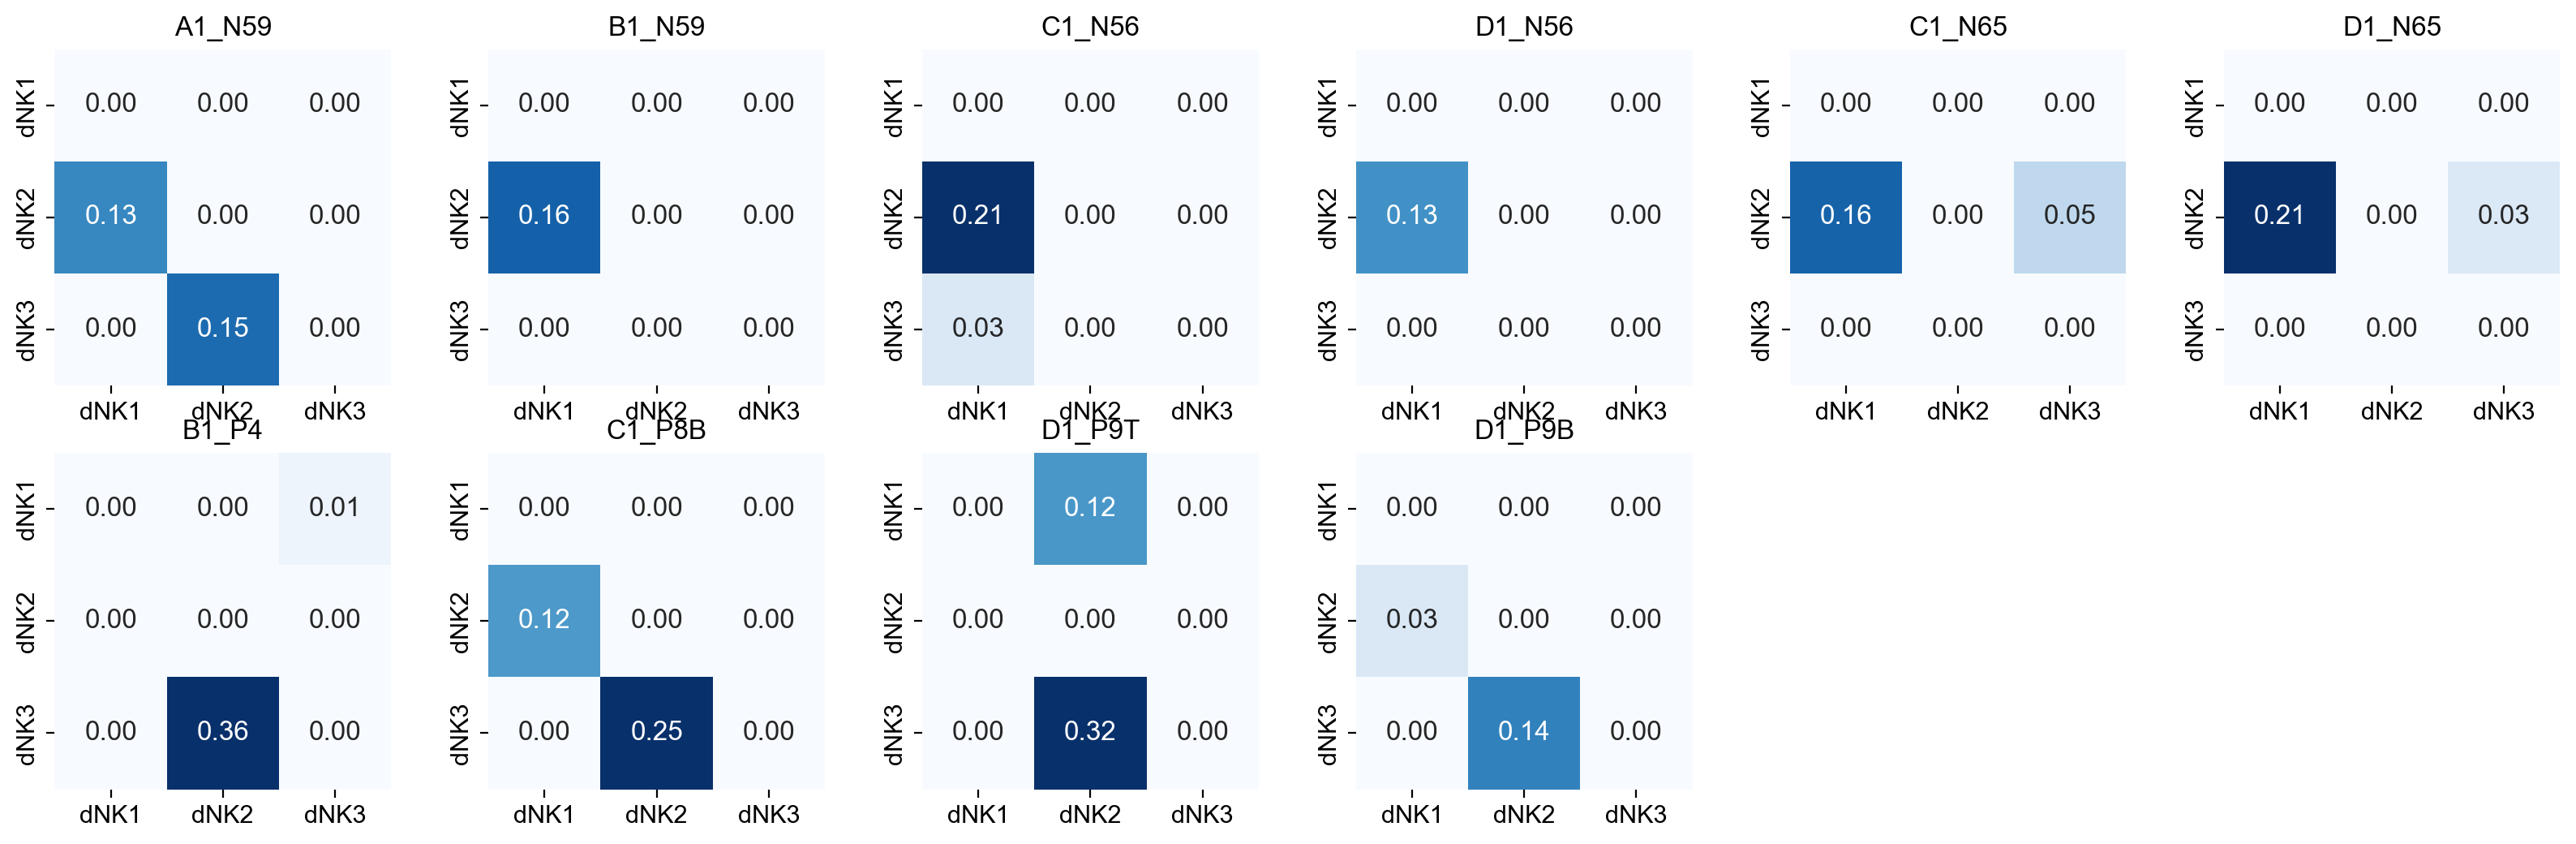

In [156]:
plt.figure(figsize=(20,6))

count = 0 
for slide in normal_slices+disease_slices:
    ctype_df = page_ctype_dict[slide]
    ax21 = plt.subplot(2,6,count+1)
    sns.heatmap(ctype_df, cmap='Blues', vmin=0, vmax=0.2, annot=True, fmt=".2f", square=True, ax=ax21, cbar=False)
    count += 1
    _ = ax21.set_title(slide)

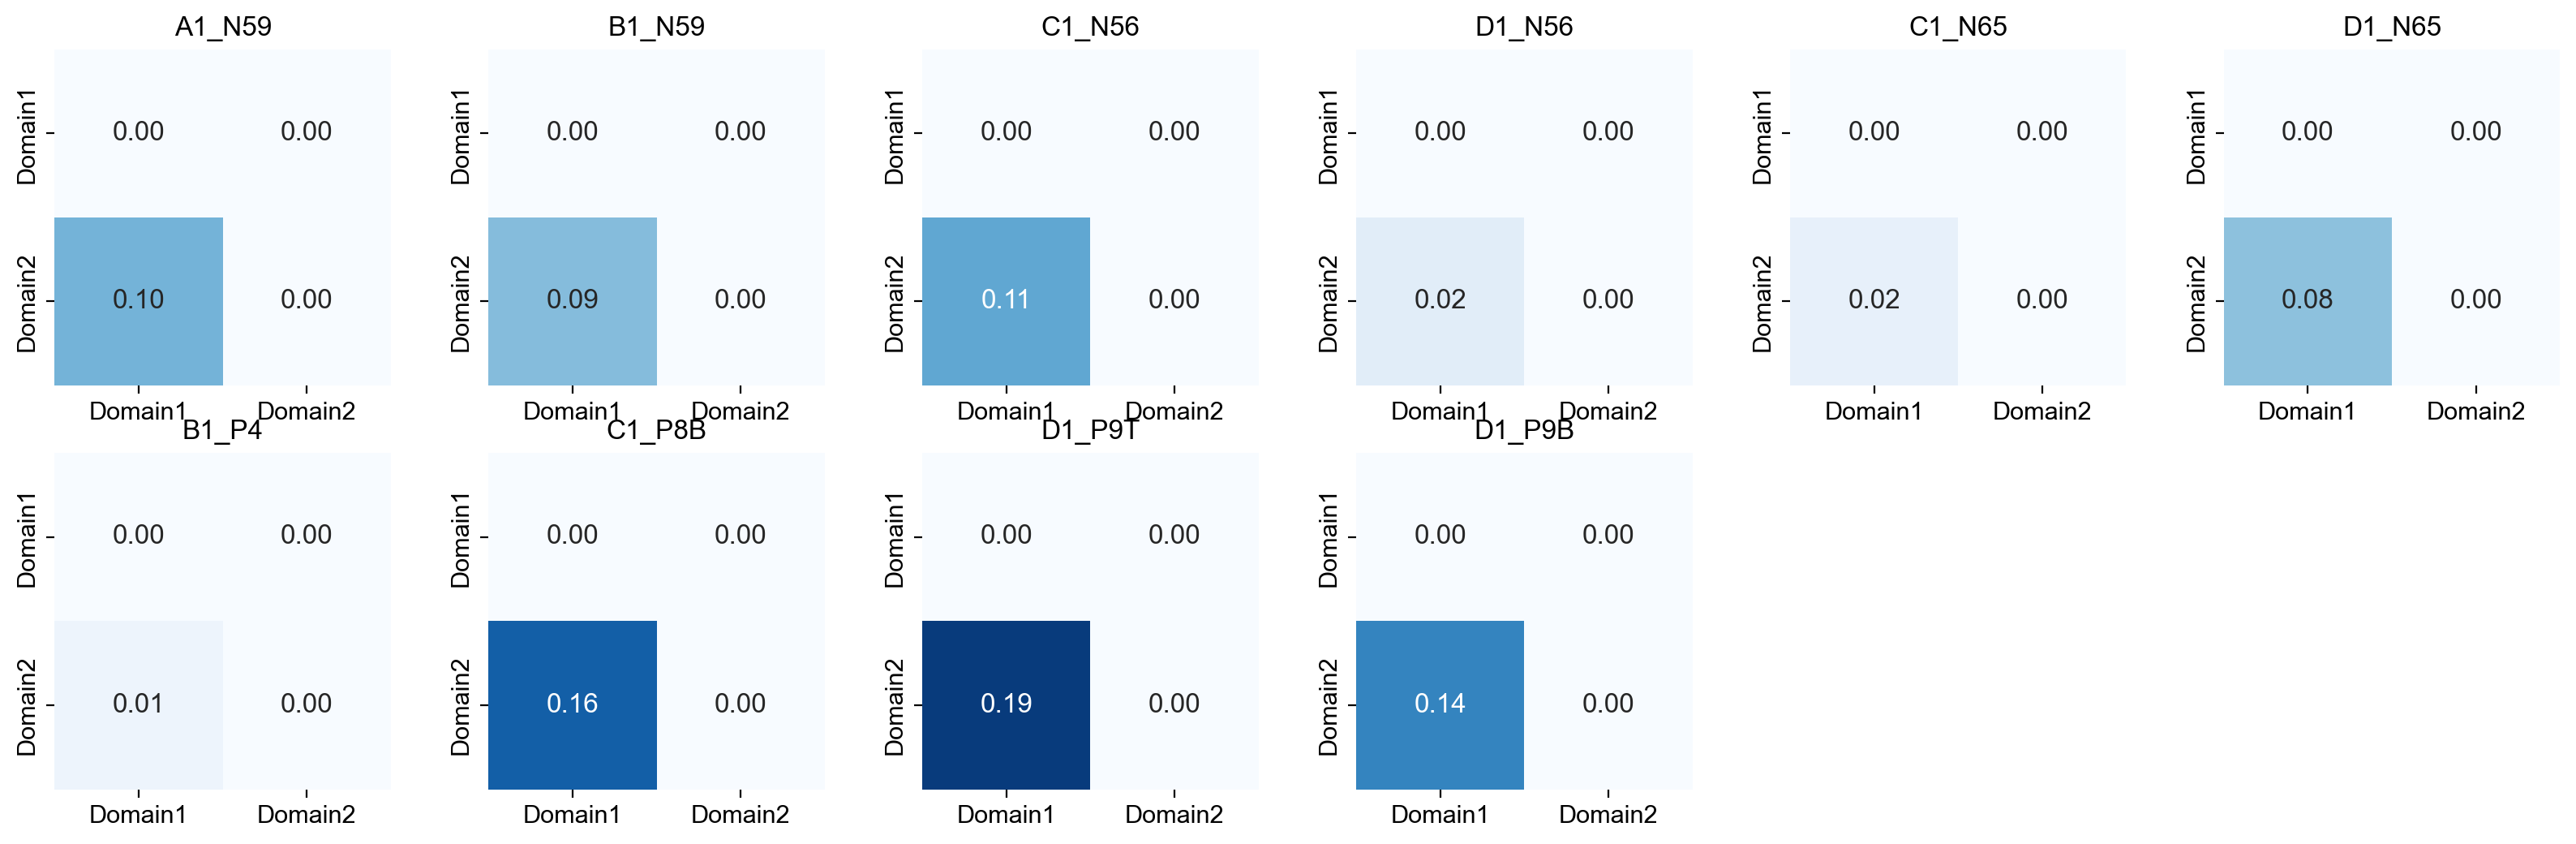

In [157]:
plt.figure(figsize=(20,6))

count = 0 
for slide in normal_slices+disease_slices:
    domain_df = page_domain_dict[slide]
    ax21 = plt.subplot(2,6,count+1)
    sns.heatmap(domain_df, cmap='Blues', vmin=0, vmax=0.2, annot=True, fmt=".2f", square=True, ax=ax21, cbar=False)
    count += 1
    _ = ax21.set_title(slide)

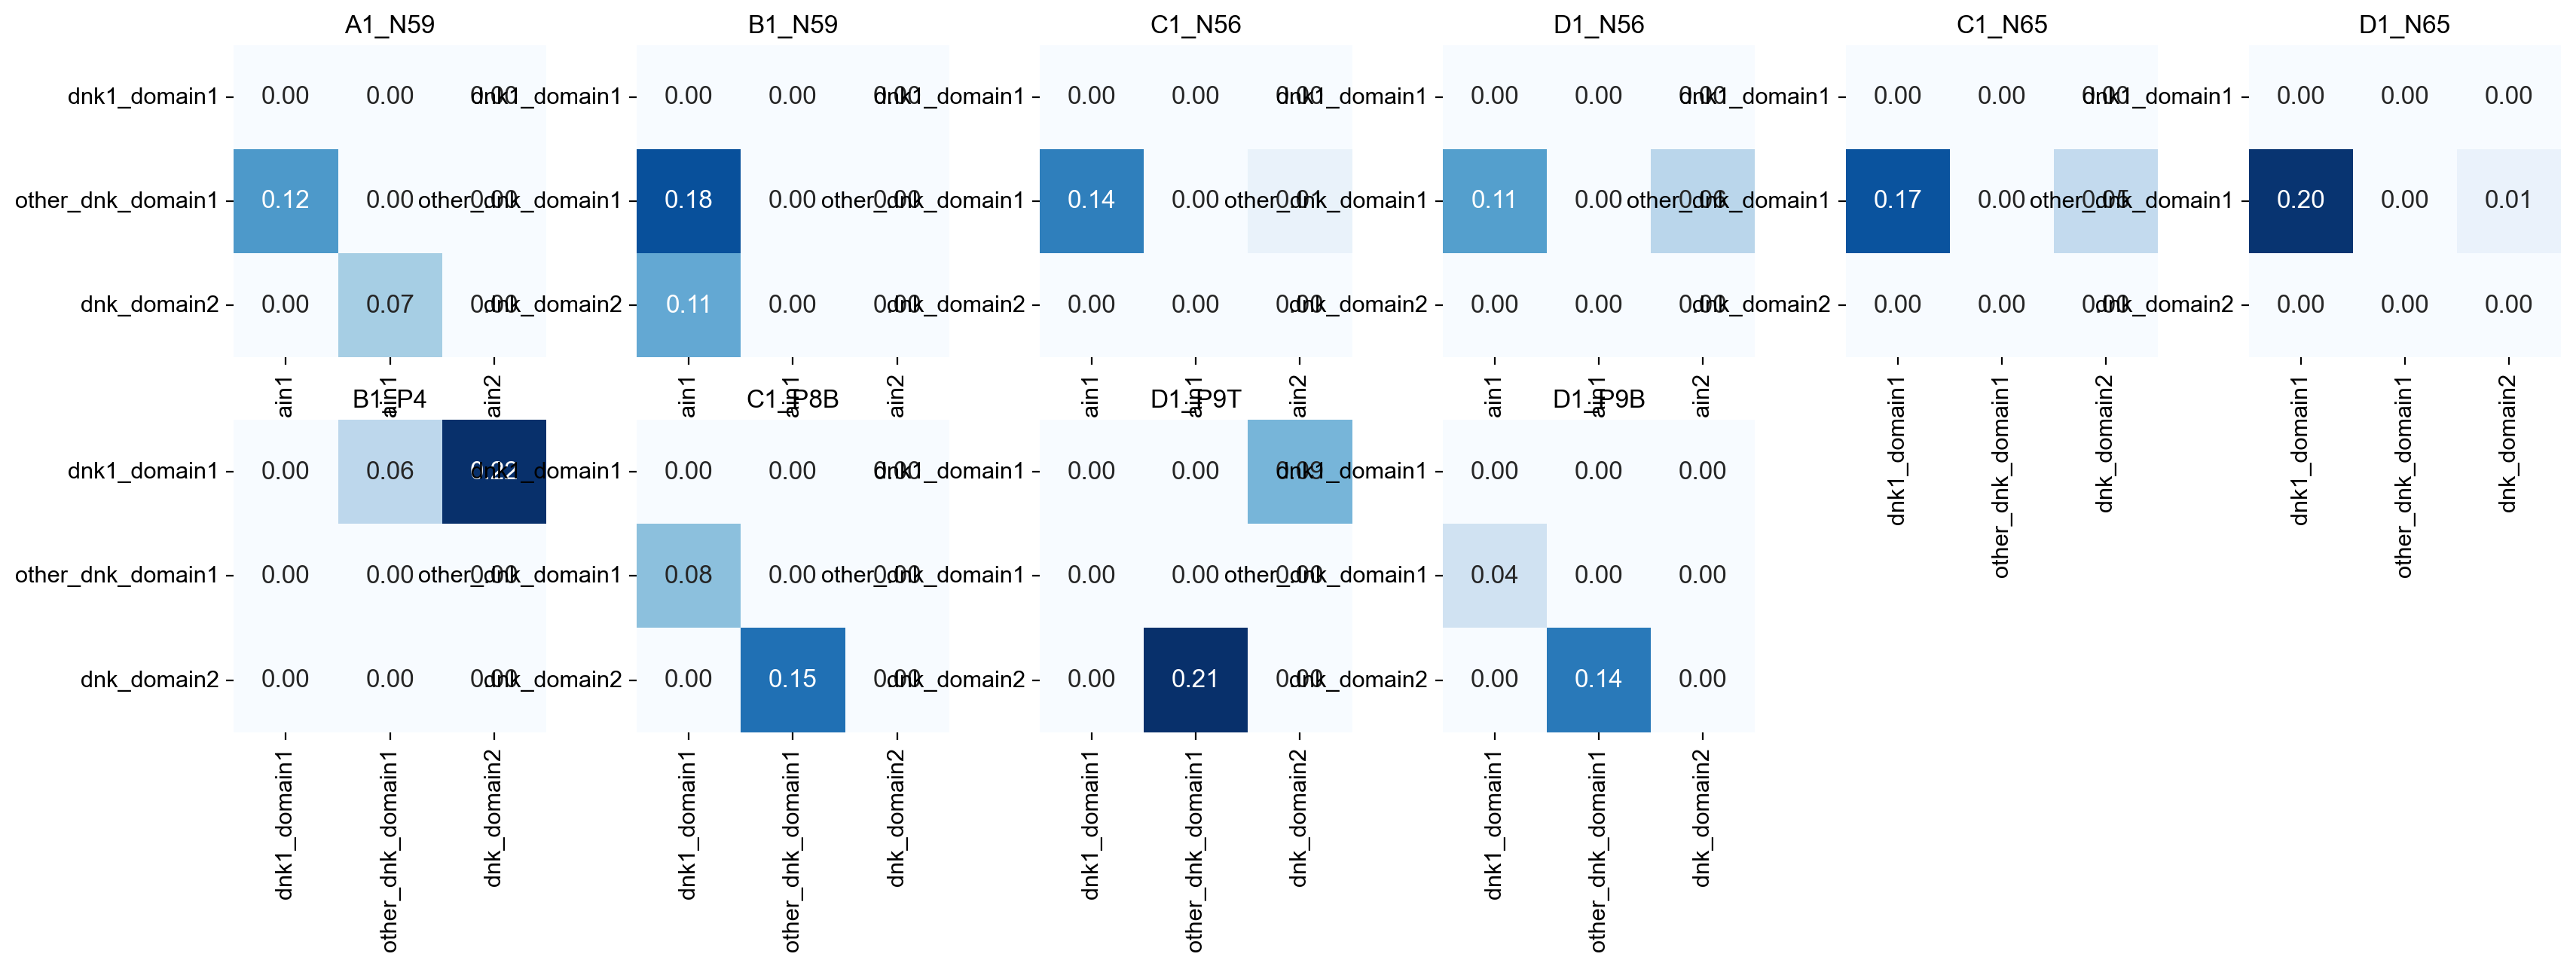

In [158]:
plt.figure(figsize=(20,6))

count = 0 
for slide in normal_slices+disease_slices:
    ctype_domain_df = page_ctype_domain_dict[slide]
    ax21 = plt.subplot(2,6,count+1)
    sns.heatmap(ctype_domain_df, cmap='Blues', vmin=0, vmax=0.2, annot=True, fmt=".2f", square=True, ax=ax21, cbar=False)
    count += 1
    _ = ax21.set_title(slide)

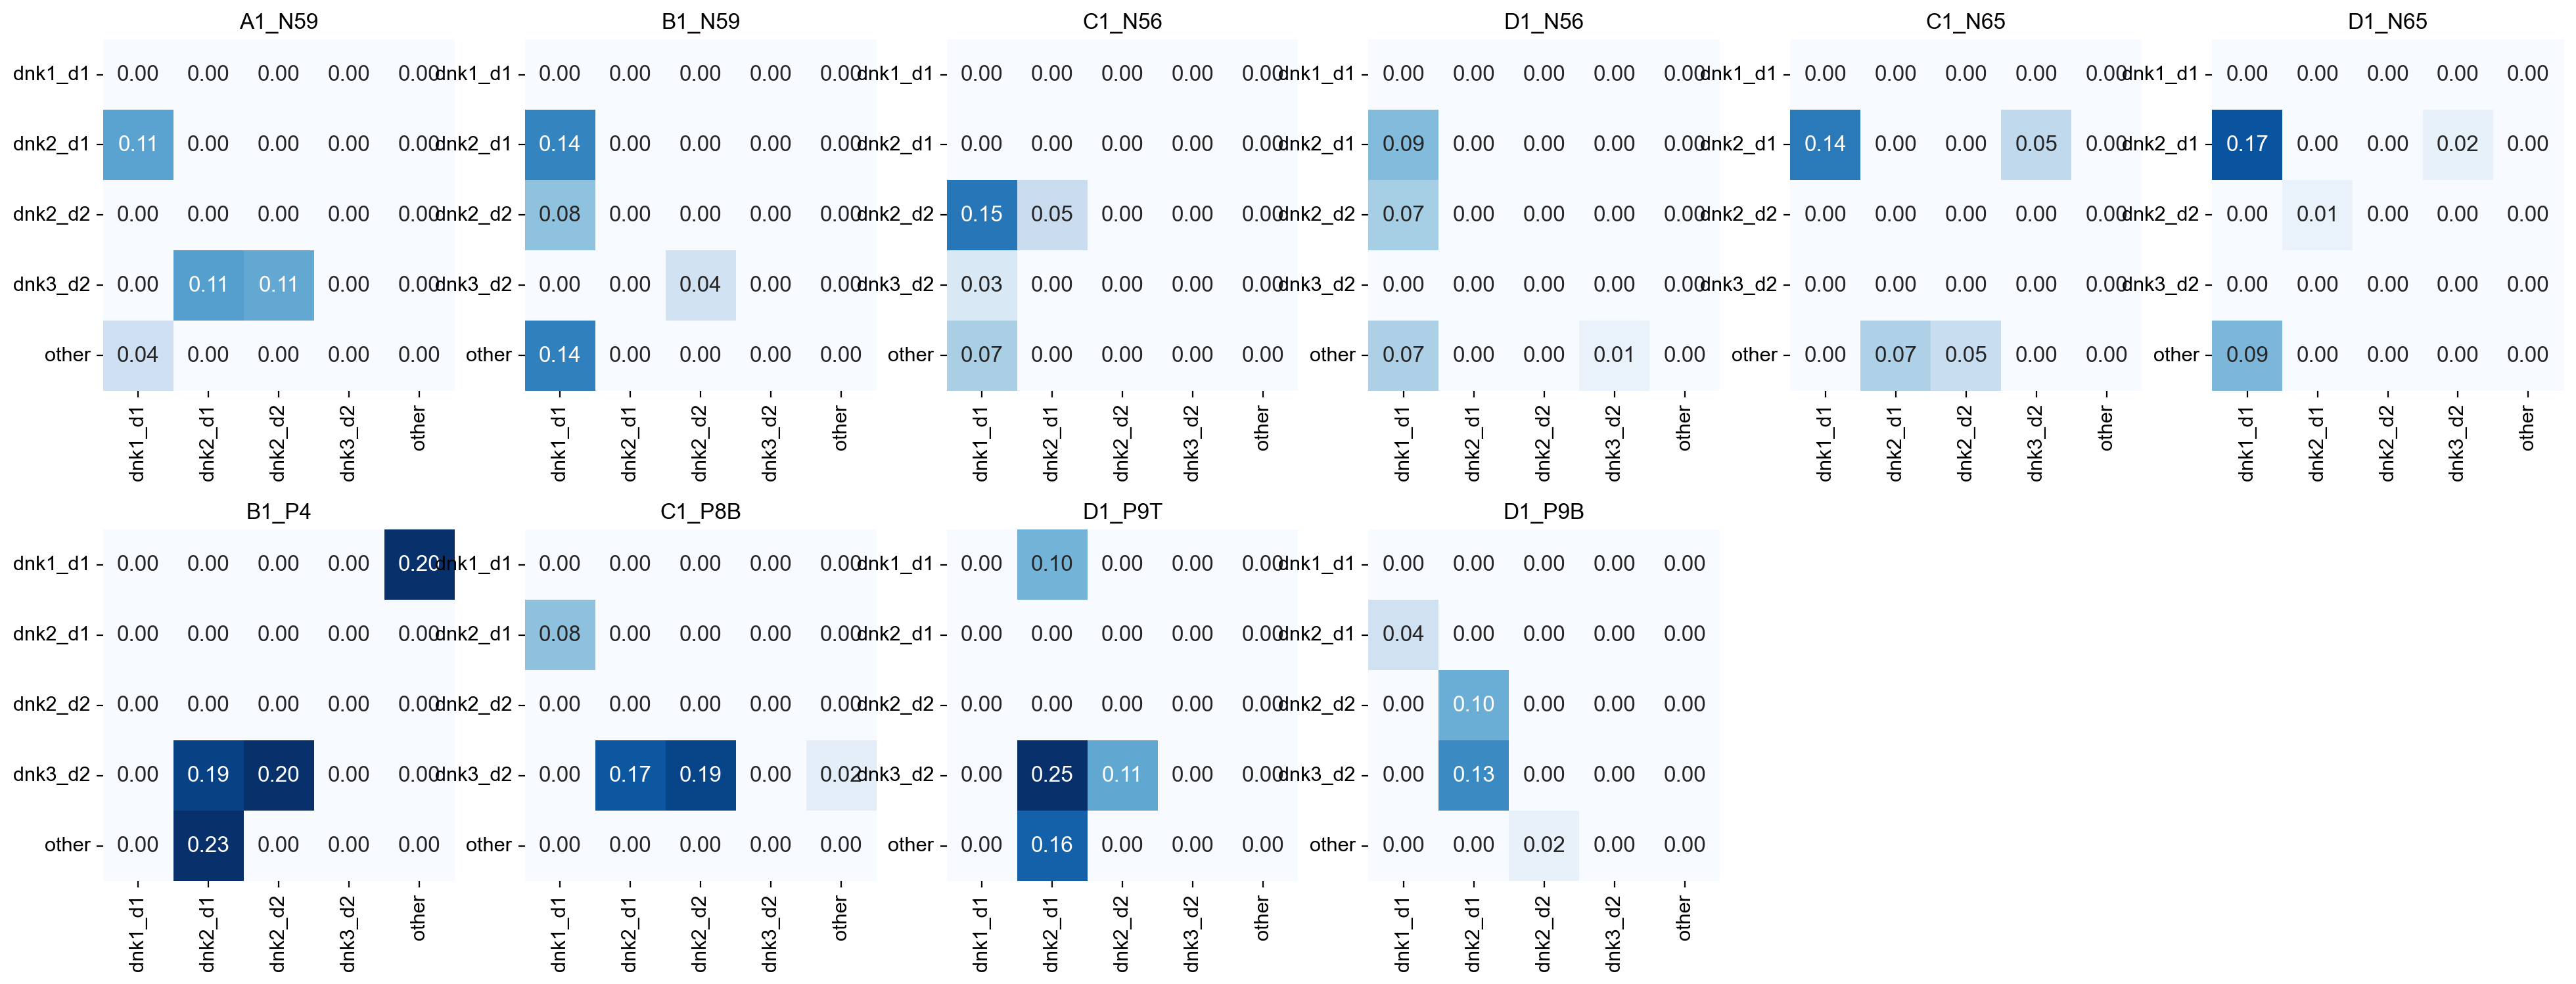

In [28]:
plt.figure(figsize=(24,9))

count = 0 
for slide in normal_slices+disease_slices:
    ctype_domain_df = page_ctype_domain2_dict[slide]
    ax21 = plt.subplot(2,6,count+1)
    sns.heatmap(ctype_domain_df, cmap='Blues', vmin=0, vmax=0.2, annot=True, fmt=".2f", square=True, ax=ax21, cbar=False)
    count += 1
    _ = ax21.set_title(slide)

In [169]:
dnk2_to_dnk1_conf_ls = []
d2_to_other_dnk_conf_ls = []
d2_to_dnk1_conf_ls = []
d1_other_dnk_to_dnk1_conf_ls = []
state_ls = []

for slide in normal_slices:
    ctype_df = page_ctype_dict[slide]
    domain_df = page_domain_dict[slide]
    ctype_domain_df = page_ctype_domain_dict[slide]
    
    dnk2_to_dnk1_conf_ls.append(ctype_df.loc['dNK2','dNK1'])
    d2_to_other_dnk_conf_ls.append(ctype_domain_df.loc['dnk_domain2','other_dnk_domain1'])
    d2_to_dnk1_conf_ls.append(ctype_domain_df.loc['dnk_domain2','dnk1_domain1'])
    d1_other_dnk_to_dnk1_conf_ls.append(ctype_domain_df.loc['other_dnk_domain1','dnk1_domain1'])
    state_ls.append('Ctrl')
    
for slide in disease_slices:
    ctype_df = page_ctype_dict[slide]
    domain_df = page_domain_dict[slide]
    ctype_domain_df = page_ctype_domain_dict[slide]
    
    dnk2_to_dnk1_conf_ls.append(ctype_df.loc['dNK2','dNK1'])
    d2_to_other_dnk_conf_ls.append(ctype_domain_df.loc['dnk_domain2','other_dnk_domain1'])
    d2_to_dnk1_conf_ls.append(ctype_domain_df.loc['dnk_domain2','dnk1_domain1'])
    d1_other_dnk_to_dnk1_conf_ls.append(ctype_domain_df.loc['other_dnk_domain1','dnk1_domain1'])
    state_ls.append('RPL')

In [181]:
result_df = pd.DataFrame({'dNK2_to_dNK1':dnk2_to_dnk1_conf_ls, 'D2_to_D1_other_dNK':d2_to_other_dnk_conf_ls, 
                          'D2_to_D1_dNK1':d2_to_dnk1_conf_ls, 'D1_other_dNK_to_dNK1':d1_other_dnk_to_dnk1_conf_ls, 'state':state_ls})

In [183]:
result_df = pd.melt(result_df, id_vars=['state'], value_vars=['dNK2_to_dNK1','D2_to_D1_other_dNK','D2_to_D1_dNK1','D1_other_dNK_to_dNK1'])

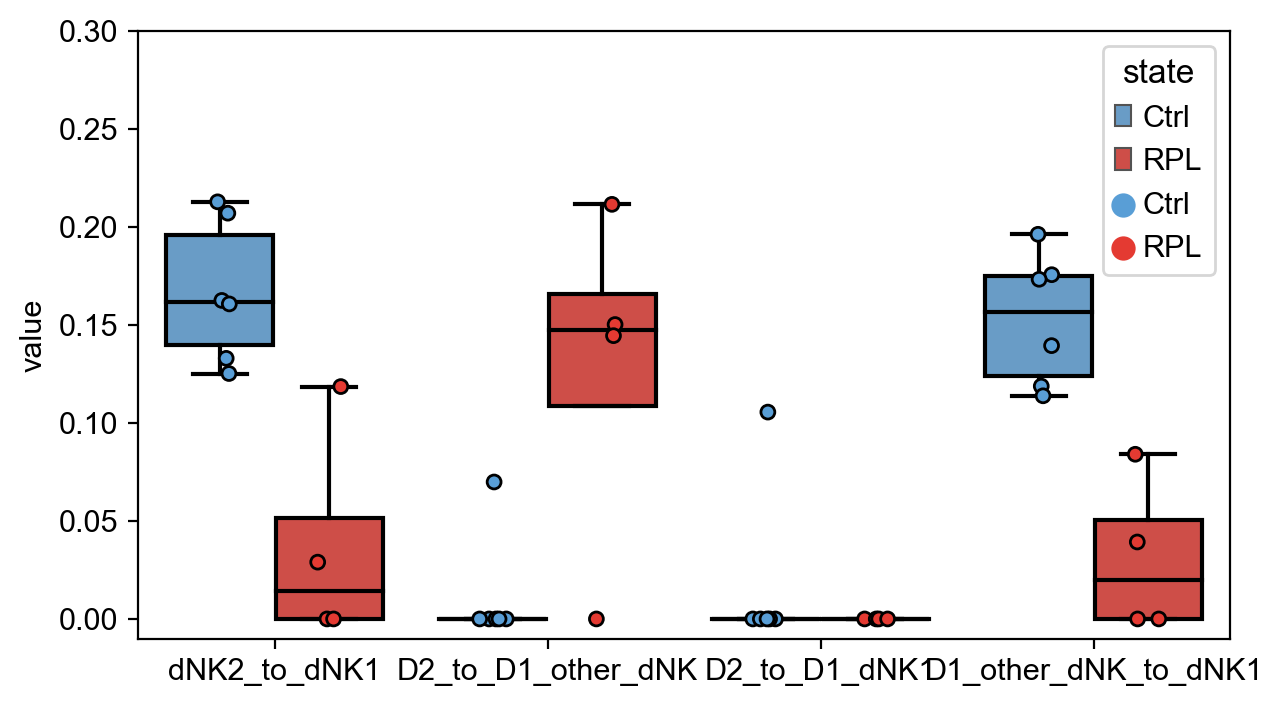

In [192]:
fig = plt.figure(figsize=(7,4))
ax21 = plt.subplot(111)
g = sns.boxplot(x='variable', y='value', hue='state', data=result_df, ax=ax21, fliersize=0, 
                palette=['#599ed6','#e43a32'], **PROPS)
sns.stripplot(x='variable', y='value', hue='state', data=result_df, linewidth=1, ax=ax21, 
              palette=['#599ed6','#e43a32'], size=5, edgecolor='black', dodge=True)
_ = ax21.set_xlabel('')
_ = ax21.set_ylim([-0.01,0.3])

In [208]:
sel_result_df = result_df[(result_df['variable']=='D2_to_D1_dNK1') | (result_df['variable']=='D1_other_dNK_to_dNK1')]

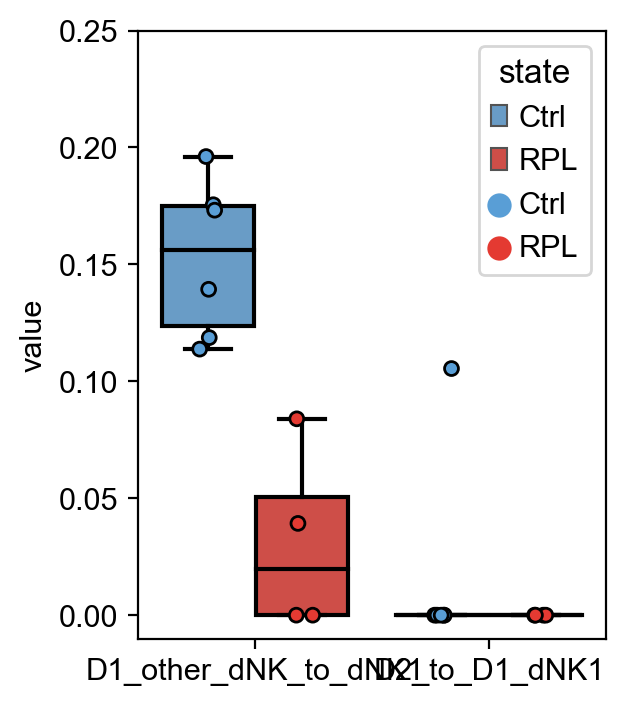

In [218]:
fig = plt.figure(figsize=(3,4))
ax21 = plt.subplot(111)
g = sns.boxplot(x='variable', y='value', hue='state', data=sel_result_df, ax=ax21, fliersize=0, 
                palette=['#599ed6','#e43a32'], **PROPS, order=['D1_other_dNK_to_dNK1', 'D2_to_D1_dNK1'])
sns.stripplot(x='variable', y='value', hue='state', data=sel_result_df, linewidth=1, ax=ax21, 
              palette=['#599ed6','#e43a32'], size=5, edgecolor='black', dodge=True, 
              order=['D1_other_dNK_to_dNK1', 'D2_to_D1_dNK1'])
_ = ax21.set_xlabel('')
_ = ax21.set_ylim([-0.01,0.25])
plt.savefig(outdir+'/Paga_transition.boxplot.pdf')

In [217]:
for item in ['D2_to_D1_dNK1','D1_other_dNK_to_dNK1']:
    tmp_df = sel_result_df[sel_result_df['variable']==item]
    pval = ranksums(tmp_df[tmp_df['state']=='Ctrl']['value'], tmp_df[tmp_df['state']=='RPL']['value'])[1]
    print(item, pval)

D2_to_D1_dNK1 0.6698153575994166
D1_other_dNK_to_dNK1 0.010515245935858907


In [195]:
ctrl_page_ctype_domain_df = (page_ctype_domain_dict[normal_slices[0]]+page_ctype_domain_dict[normal_slices[1]]+page_ctype_domain_dict[normal_slices[2]]+page_ctype_domain_dict[normal_slices[3]]+page_ctype_domain_dict[normal_slices[4]]+page_ctype_domain_dict[normal_slices[5]])/6
rpl_page_ctype_domain_df = (page_ctype_domain_dict[disease_slices[0]]+page_ctype_domain_dict[disease_slices[1]]+page_ctype_domain_dict[disease_slices[2]]+page_ctype_domain_dict[disease_slices[3]])/4

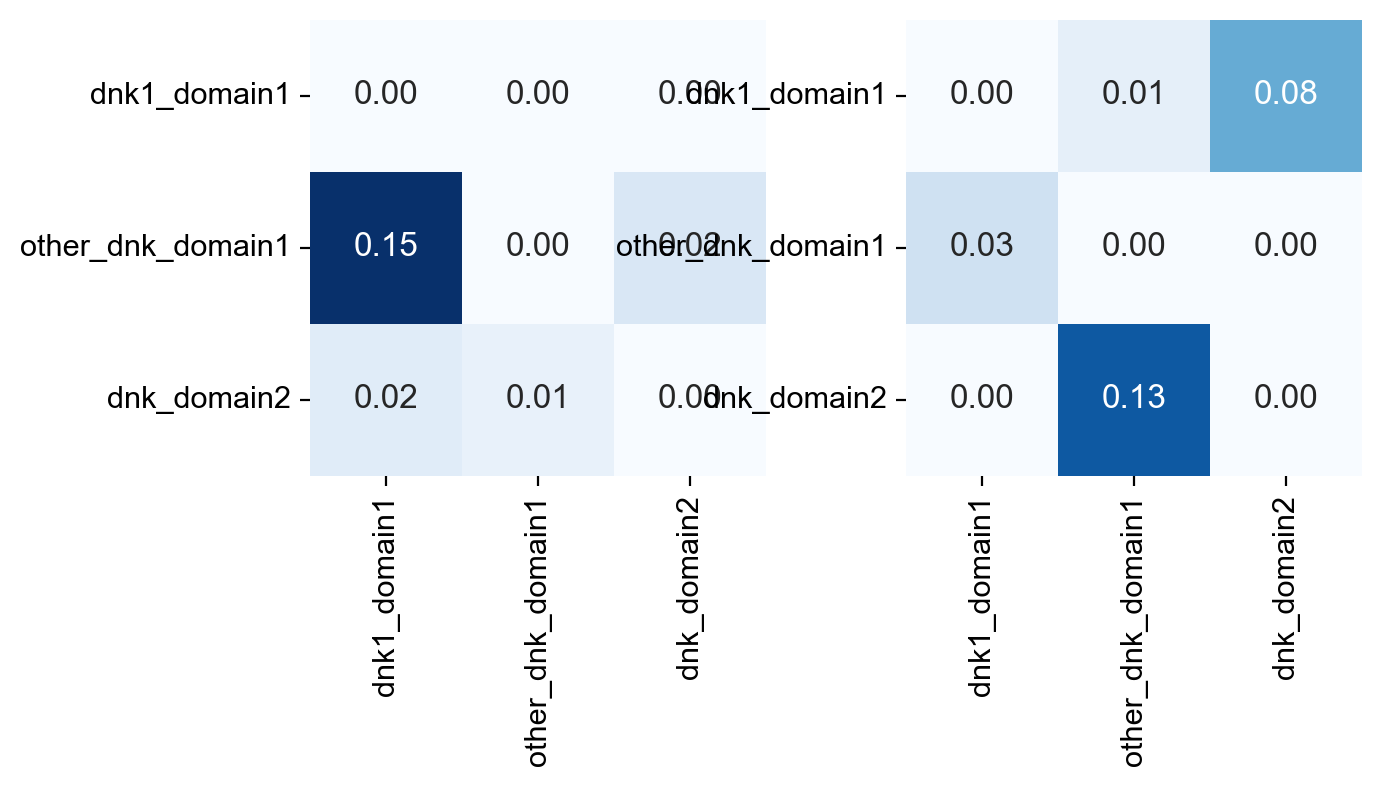

In [204]:
plt.figure(figsize=(7,3))
ax21 = plt.subplot(121)
sns.heatmap(ctrl_page_ctype_domain_df, cmap='Blues', vmin=0, vmax=0.15, annot=True, fmt=".2f", 
            square=True, ax=ax21, cbar=False)
ax21 = plt.subplot(122)
sns.heatmap(rpl_page_ctype_domain_df, cmap='Blues', vmin=0, vmax=0.15, annot=True, fmt=".2f", 
            square=True, ax=ax21, cbar=False)
plt.savefig(outdir+'/Paga_transition.pdf')

In [203]:
outdir

'/home/yuqiaoni/decidua/10xVisium/plot/new/RPL'

In [197]:
rpl_page_ctype_domain_df

,dnk1_domain1,other_dnk_domain1,dnk_domain2
dnk1_domain1,0.00,0.01,0.08
other_dnk_domain1,0.03,0.00,0.00
dnk_domain2,0.00,0.13,0.00


In [35]:
items = []
for a in page_ctype_domain2_dict[slide].columns:
    for b in page_ctype_domain2_dict[slide].columns:
        if a != b:
            items.append(a+'_to_'+b)

In [46]:
result_df = pd.DataFrame(index=items, columns=normal_slices+disease_slices)

for slide in normal_slices+disease_slices:
    ctype_domain_df = page_ctype_domain2_dict[slide]
    
    for item in items:
        result_df.loc[item,slide] = ctype_domain_df.loc[item.split('_to_')[0], item.split('_to_')[1]]
        
result_df = result_df.applymap(float)

In [48]:
result_df['item'] = result_df.index

In [53]:
plot_df = pd.melt(result_df, id_vars=['item'])

In [55]:
plot_df['state'] = plot_df['variable'].map(lambda x: 'Ctrl' if x in normal_slices else 'RPL')

In [86]:
sel_items = []
for item in items:
    tmp_df = plot_df[plot_df['item']==item]
    # pval = ranksums(tmp_df[tmp_df['state']=='Ctrl']['value'], tmp_df[tmp_df['state']=='RPL']['value'])[1]
    pval = ttest_ind(tmp_df[tmp_df['state']=='Ctrl']['value'], tmp_df[tmp_df['state']=='RPL']['value'], equal_var=False)[1]
    # print(item, pval)
    if pval < 0.2:
        print(item, pval)
        sel_items.append(item)

dnk2_d1_to_dnk1_d1 0.03951738971515571
dnk2_d2_to_dnk1_d1 0.09911145107663959
dnk3_d2_to_dnk2_d1 0.0014440759722185467
dnk3_d2_to_dnk2_d2 0.11632144697351837
other_to_dnk1_d1 0.016298441301732018


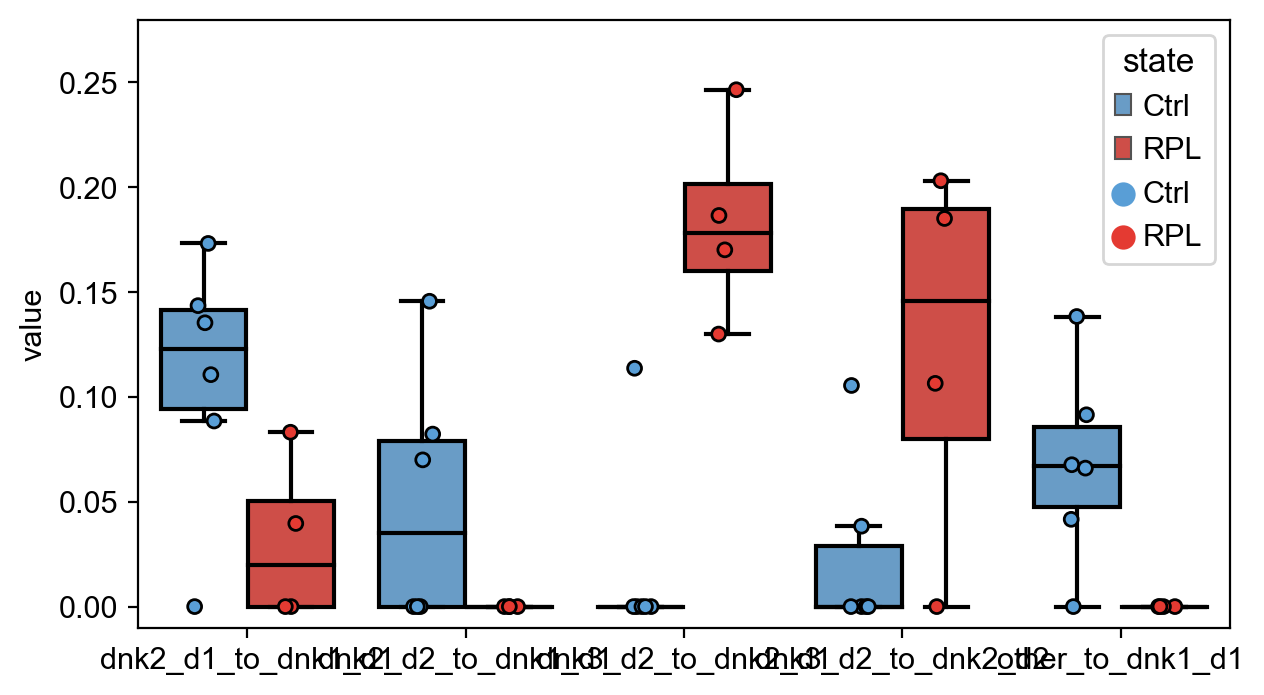

In [92]:
fig = plt.figure(figsize=(7,4))
ax21 = plt.subplot(111)
g = sns.boxplot(x='item', y='value', hue='state', data=plot_df, ax=ax21, fliersize=0, 
                palette=['#599ed6','#e43a32'], order=sel_items, **PROPS)
sns.stripplot(x='item', y='value', hue='state', data=plot_df, linewidth=1, ax=ax21, 
              palette=['#599ed6','#e43a32'], order=sel_items, size=5, edgecolor='black', dodge=True)
_ = ax21.set_xlabel('')
_ = ax21.set_ylim([-0.01,0.28])
plt.savefig(outdir+'/Paga_transition2.boxplot.pdf')

In [77]:
ctrl_page_ctype_domain_df = (page_ctype_domain2_dict[normal_slices[0]]+page_ctype_domain2_dict[normal_slices[1]]+page_ctype_domain2_dict[normal_slices[2]]+page_ctype_domain2_dict[normal_slices[3]]+page_ctype_domain2_dict[normal_slices[4]]+page_ctype_domain2_dict[normal_slices[5]])/6
rpl_page_ctype_domain_df = (page_ctype_domain2_dict[disease_slices[0]]+page_ctype_domain2_dict[disease_slices[1]]+page_ctype_domain2_dict[disease_slices[2]]+page_ctype_domain2_dict[disease_slices[3]])/4

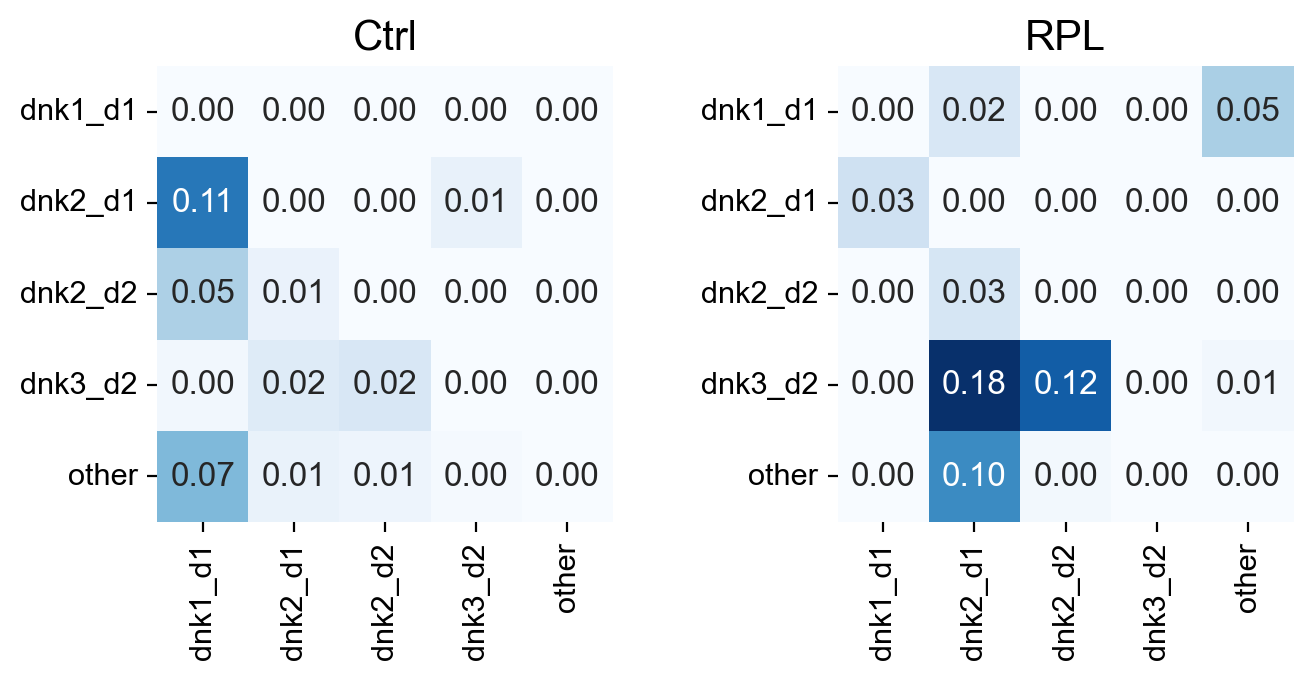

In [85]:
plt.figure(figsize=(8,3))
ax21 = plt.subplot(121)
sns.heatmap(ctrl_page_ctype_domain_df, cmap='Blues', vmin=0, vmax=0.15, annot=True, fmt=".2f", 
            square=True, ax=ax21, cbar=False)
_ = ax21.set_title('Ctrl', fontsize=15)
ax21 = plt.subplot(122)
sns.heatmap(rpl_page_ctype_domain_df, cmap='Blues', vmin=0, vmax=0.15, annot=True, fmt=".2f", 
            square=True, ax=ax21, cbar=False)
_ = ax21.set_title('RPL', fontsize=15)
plt.savefig(outdir+'/Paga_transition2.pdf')